
<h1>Задание 1</h1>

У вас есть небольшой искусственный датасет: https://www.kaggle.com/datasets/iamsouravbanerjee/customer-shopping-trends-dataset/data   

Показатели:
1. Customer ID;
2. Age;
3. Gender;
4. Item Purchased - товар, купленный клиентом;
5. Category - категория товара;
6. Purchase Amount (USD) - сумма покупки;
7. Location - место, где была совершена покупка;
8. Size - размер купленного товара;
9. Color - цвет товара;
10. Season - сезон, в который была совершена покупка;
11. Review Rating - рейтинг отзыва покупателя 
12. Subscription Status - наличие подписки у клиента (да/нет);
13. Shipping Type - тип доставки по выбору клиента;
14. Discount Applied - наличие скидки на покупку (да/нет)
15. Promo Code Used - использование промокода (да/нет);
16. Previous Purchases - общее количество транзакций, совершенных покупателем в магазине, за исключением текущей транзакции;
17. Payment Method - наиболее предпочтительный для клиента способ оплаты;
18. Frequency of Purchases - частота, с которой клиент совершает покупки (например, еженедельно, раз в две недели, ежемесячно).

<h2>Задание 1.1</h2>

На основании этих данных необходимо составить максимальное(но не менее пяти) количество гипотез о корреляциях между отдельными столбцами и проверить их. 

При этом при составлении гипотез можно рассматривать не полный df, а именно выборки (например: "женщины старше 40 лет покупают в основном осенью")

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from collections import Counter
import string

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('shopping_trends_updated.csv')
data.head()

,Customer ID,Age,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,Subscription Status,Shipping Type,Discount Applied,Promo Code Used,Previous Purchases,Payment Method,Frequency of Purchases
0,1,55,Male,Blouse,Clothing,53,Kentucky,L,Gray,Winter,3.1,Yes,Express,Yes,Yes,14,Venmo,Fortnightly
1,2,19,Male,Sweater,Clothing,64,Maine,L,Maroon,Winter,3.1,Yes,Express,Yes,Yes,2,Cash,Fortnightly
2,3,50,Male,Jeans,Clothing,73,Massachusetts,S,Maroon,Spring,3.1,Yes,Free Shipping,Yes,Yes,23,Credit Card,Weekly
3,4,21,Male,Sandals,Footwear,90,Rhode Island,M,Maroon,Spring,3.5,Yes,Next Day Air,Yes,Yes,49,PayPal,Weekly
4,5,45,Male,Blouse,Clothing,49,Oregon,M,Turquoise,Spring,2.7,Yes,Free Shipping,Yes,Yes,31,PayPal,Annually


In [3]:
print(data.shape[0])
print(data['Customer ID'].nunique())
# --> для каждого покупателя существует всего одна запись 

3900
3900


In [4]:
data.info()
# --> пустых значений нет

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Customer ID             3900 non-null   int64  
 1   Age                     3900 non-null   int64  
 2   Gender                  3900 non-null   object 
 3   Item Purchased          3900 non-null   object 
 4   Category                3900 non-null   object 
 5   Purchase Amount (USD)   3900 non-null   int64  
 6   Location                3900 non-null   object 
 7   Size                    3900 non-null   object 
 8   Color                   3900 non-null   object 
 9   Season                  3900 non-null   object 
 10  Review Rating           3900 non-null   float64
 11  Subscription Status     3900 non-null   object 
 12  Shipping Type           3900 non-null   object 
 13  Discount Applied        3900 non-null   object 
 14  Promo Code Used         3900 non-null   

In [5]:
# анализ количественных показателей 
data.describe().applymap(lambda x: f"{x:.2f}")[['Age', 'Purchase Amount (USD)', 'Review Rating', 'Previous Purchases']]

,Age,Purchase Amount (USD),Review Rating,Previous Purchases
count,3900.00,3900.00,3900.00,3900.00
mean,44.07,59.76,3.75,25.35
std,15.21,23.69,0.72,14.45
min,18.00,20.00,2.50,1.00
25%,31.00,39.00,3.10,13.00
50%,44.00,60.00,3.70,25.00
75%,57.00,81.00,4.40,38.00
max,70.00,100.00,5.00,50.00


In [6]:
# анализ качественных показателей 
data.describe(include=['object'])[['Gender', 'Item Purchased', 'Category', 'Location', 'Size', 'Color', 'Season', 'Subscription Status', 'Shipping Type', 'Discount Applied', 'Promo Code Used', 'Payment Method', 'Frequency of Purchases']]

,Gender,Item Purchased,Category,Location,Size,Color,Season,Subscription Status,Shipping Type,Discount Applied,Promo Code Used,Payment Method,Frequency of Purchases
count,3900,3900,3900,3900,3900,3900,3900,3900,3900,3900,3900,3900,3900
unique,2,25,4,50,4,25,4,2,6,2,2,6,7
top,Male,Blouse,Clothing,Montana,M,Olive,Spring,No,Free Shipping,No,No,PayPal,Every 3 Months
freq,2652,171,1737,96,1755,177,999,2847,675,2223,2223,677,584


1. Гипотеза 1: клиенты с подпиской совершают покупки чаще, чем клиенты без неё.

In [7]:
print('Уникальные значения частоты покупок:', data['Frequency of Purchases'].unique())
# словарь для замены значений показателя на количественные в порядке возврастания частоты 
frequency_mapping = {
    'Annually': 1,
    'Every 3 Months': 4,
    'Quarterly': 4,
    'Fortnightly': 26, # раз в две недели
    'Monthly': 12,
    'Weekly': 52,
    'Bi-Weekly': 104 # два раза в неделю
}
data['Frequency of Purchases'] = data['Frequency of Purchases'].replace(frequency_mapping)
data

Уникальные значения частоты покупок: ['Fortnightly' 'Weekly' 'Annually' 'Quarterly' 'Bi-Weekly' 'Monthly'
 'Every 3 Months']


,Customer ID,Age,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,Subscription Status,Shipping Type,Discount Applied,Promo Code Used,Previous Purchases,Payment Method,Frequency of Purchases
0,1,55,Male,Blouse,Clothing,53,Kentucky,L,Gray,Winter,3.1,Yes,Express,Yes,Yes,14,Venmo,26
1,2,19,Male,Sweater,Clothing,64,Maine,L,Maroon,Winter,3.1,Yes,Express,Yes,Yes,2,Cash,26
2,3,50,Male,Jeans,Clothing,73,Massachusetts,S,Maroon,Spring,3.1,Yes,Free Shipping,Yes,Yes,23,Credit Card,52
3,4,21,Male,Sandals,Footwear,90,Rhode Island,M,Maroon,Spring,3.5,Yes,Next Day Air,Yes,Yes,49,PayPal,52
4,5,45,Male,Blouse,Clothing,49,Oregon,M,Turquoise,Spring,2.7,Yes,Free Shipping,Yes,Yes,31,PayPal,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3895,3896,40,Female,Hoodie,Clothing,28,Virginia,L,Turquoise,Summer,4.2,No,2-Day Shipping,No,No,32,Venmo,52
3896,3897,52,Female,Backpack,Accessories,49,Iowa,L,White,Spring,4.5,No,Store Pickup,No,No,41,Bank Transfer,104
3897,3898,46,Female,Belt,Accessories,33,New Jersey,L,Green,Spring,2.9,No,Standard,No,No,24,Venmo,4
3898,3899,44,Female,Shoes,Footwear,77,Minnesota,S,Brown,Summer,3.8,No,Express,No,No,24,Venmo,52


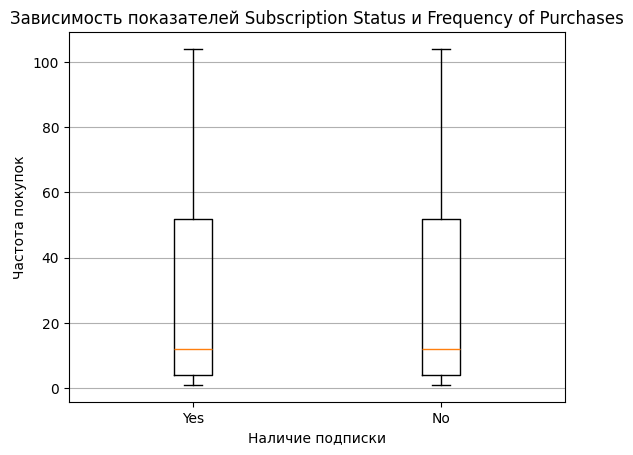

In [8]:
# зависимость частоты покупок от наличия подписки (качественный и количественный параметры)
# список сгруппированных по параметру Subscription Status данных 
grouped_data = [data['Frequency of Purchases'][data['Subscription Status'] == category] for category in data['Subscription Status'].unique()]
plt.boxplot(grouped_data, labels=data['Subscription Status'].unique())
plt.title('Зависимость показателей Subscription Status и Frequency of Purchases')
plt.ylabel('Частота покупок')
plt.xlabel('Наличие подписки')
plt.grid(axis='y')
plt.show()

In [9]:
average_frequency = data.groupby('Subscription Status')['Frequency of Purchases'].mean()

print("Средняя частота покупок для каждой группы:")
print(average_frequency)
# --> клиенты с подпиской заказывают больше товаров, чем клиенты без подписки 

Средняя частота покупок для каждой группы:
Subscription Status
No     28.443274
Yes    28.324786
Name: Frequency of Purchases, dtype: float64


2. Гипотеза 2: клиенты, не имеющие подписки, обычно не используют промокоды и наоборот.

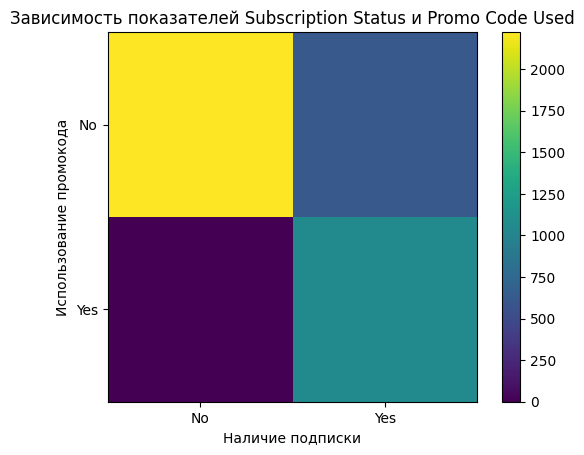

In [10]:
# зависимость использования промокода от наличия подписки (два качественных показателя)
# таблица сопряженности
table = pd.crosstab(data['Subscription Status'], data['Promo Code Used'])
plt.imshow(table)
plt.title('Зависимость показателей Subscription Status и Promo Code Used')
plt.xlabel('Наличие подписки')
plt.ylabel('Использование промокода')
plt.xticks(range(len(table.columns)), table.columns)
plt.yticks(range(len(table.index)), table.index)
plt.colorbar()
plt.show()
# --> клиенты без подписки чаще не используют промокоды, клиенты с подпиской - чаще используют 

3. Гипотеза 3: женщины чаще покупают вещи чёрного цвета.

In [11]:
# только чёрные вещи
black_items = data[data['Color'] == 'Black']
# разбиение на группы
women_black = black_items[black_items['Gender'] == 'Female']
men_black = black_items[black_items['Gender'] == 'Male']
women_count = len(women_black)
men_count = len(men_black)

print(f"Количество покупок чёрных вещей женщинами: {women_count}")
print(f"Количество покупок чёрных вещей мужчинами: {men_count}")
# --> гипотеза опровергнута - мужчины покупают больше чёрных вещей 

Количество покупок чёрных вещей женщинами: 54
Количество покупок чёрных вещей мужчинами: 113


4. Гипотеза 4: среди клиентов до 35 лет рейтинг отзыва выше, чем среди клиентов старше 35.

In [12]:
group1 = data[data['Age'] <= 35]
group2 = data[data['Age'] > 35] 
mean_rating_group1 = group1['Review Rating'].mean()
mean_rating_group2 = group2['Review Rating'].mean()

print(f"Средний рейтинг отзыва для клиентов до 35 лет: {mean_rating_group1}")
print(f"Средний рейтинг отзыва для клиентов старше 35 лет: {mean_rating_group2}")

Средний рейтинг отзыва для клиентов до 35 лет: 3.770449352627571
Средний рейтинг отзыва для клиентов старше 35 лет: 3.7395438732122153


5. Гипотеза 5: женщины до 30 лет чаще покупают что-то зимой, чем в другие сезоны.

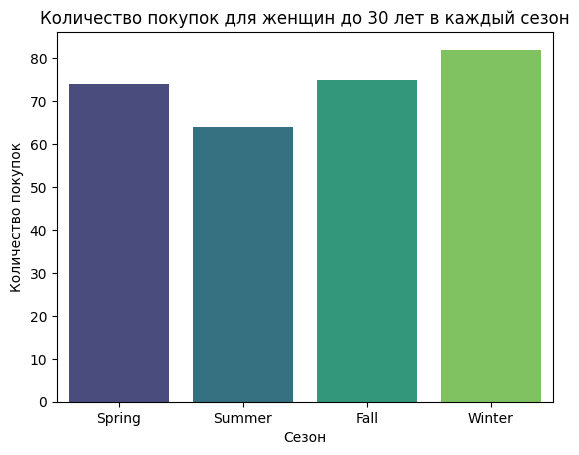

In [13]:
women_under_30 = data[(data['Gender'] == 'Female') & (data['Age'] <= 30)]
winter_women_under_30 = women_under_30[women_under_30['Season'] == 'Winter']
#количество покупок зимой для женщин до 30 лет
winter_count_women_under_30 = len(winter_women_under_30)
# общее количество покупок для женщин до 30 лет
total_count_women_under_30 = len(women_under_30)

plt.figure()
sns.countplot(x='Season', data=women_under_30, palette='viridis', order=['Spring', 'Summer', 'Fall', 'Winter'])
plt.title('Количество покупок для женщин до 30 лет в каждый сезон')
plt.xlabel('Сезон')
plt.ylabel('Количество покупок')
plt.show()
# --> гипотеза подтверждена 

<h2>Задание 1.2</h2>

Помимо гипотез:
* найдите самый популярный товар
* постройте распределение покупателей по полу
* определите, какой пол (и отдельно возраст) покупает больше всего, чаще всего, самые дорогие товары
* определите, есть ли зависимость между цветом одежды и сезоном.
* посчитайте наш сезонный mau (уникальных пользователей за сезон) и его динамику.
* найдите самую популярную букву в названии одежды. 

1. Самый популярный товар.

In [14]:
# самый популярный товар = товар, который встречается в таблице больше всего раз
# подсчёт количества покупок для кадого товара
item_counts = data['Item Purchased'].value_counts()
top_item = item_counts.idxmax()
top_item_count = item_counts.max()

print(f"Самый популярный товар: {top_item}")
print(f"Количество покупок: {top_item_count}")


Самый популярный товар: Blouse
Количество покупок: 171


2. Распределение покупателей по полу.

Gender
Male      2652
Female    1248
Name: count, dtype: int64


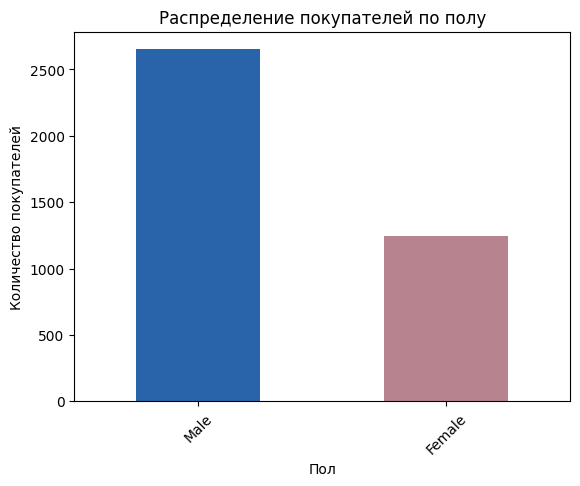

In [15]:
# подсчёт количества записей для каждого пола
gender_counts = data['Gender'].value_counts()
print(gender_counts)

gender_counts.plot(kind='bar', color=['#2964aa', '#b6838f'])
plt.title('Распределение покупателей по полу')
plt.xlabel('Пол')
plt.ylabel('Количество покупателей')
plt.xticks(rotation=45)
plt.show()

3. Пол (и отдельно возраст) клиентов, которые покупают:

    3.1 больше всего; 

    3.2 чаще всего; 

    3.3 самые дорогие товары.

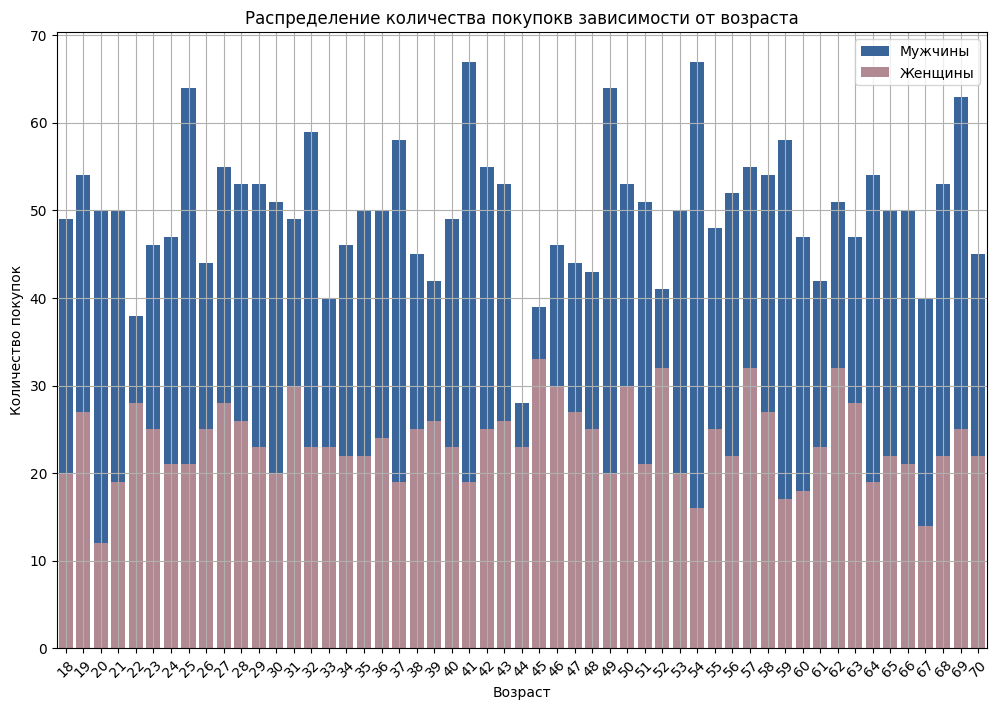

In [16]:
# 3.1 у мужчин заказов больше, чем у женщин (пред. пункт)

# зависимость количества покупок от возраста
# Фильтрация данных по полу
data_men = data[data['Gender'] == 'Male']
data_women = data[data['Gender'] == 'Female']

# количество покупок для каждого возраста покупателей одного пола
age_purchase_counts_men = data_men.groupby('Age')['Item Purchased'].count()
age_purchase_counts_women = data_women.groupby('Age')['Item Purchased'].count()

plt.figure(figsize=(12, 8))
sns.barplot(x=age_purchase_counts_men.index, y=age_purchase_counts_men.values, label='Мужчины', color='#2964aa')
sns.barplot(x=age_purchase_counts_women.index, y=age_purchase_counts_women.values, label='Женщины', color='#b6838f')
plt.title('Распределение количества покупокв зависимости от возраста')
plt.xlabel('Возраст')
plt.ylabel('Количество покупок')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [17]:
# 3.2 частота покупок

print('Уникальные значения частоты покупок:', data['Frequency of Purchases'].unique())
# словарь для замены значений показателя на количественные в порядке возврастания частоты 
frequency_mapping = {
    'Annually': 1,
    'Every 3 Months': 4,
    'Quarterly': 4,
    'Fortnightly': 26, # раз в две недели
    'Monthly': 12,
    'Weekly': 52,
    'Bi-Weekly': 104 # два раза в неделю
}
data['Frequency of Purchases'] = data['Frequency of Purchases'].replace(frequency_mapping)
data

Уникальные значения частоты покупок: [ 26  52   1   4 104  12]


,Customer ID,Age,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,Subscription Status,Shipping Type,Discount Applied,Promo Code Used,Previous Purchases,Payment Method,Frequency of Purchases
0,1,55,Male,Blouse,Clothing,53,Kentucky,L,Gray,Winter,3.1,Yes,Express,Yes,Yes,14,Venmo,26
1,2,19,Male,Sweater,Clothing,64,Maine,L,Maroon,Winter,3.1,Yes,Express,Yes,Yes,2,Cash,26
2,3,50,Male,Jeans,Clothing,73,Massachusetts,S,Maroon,Spring,3.1,Yes,Free Shipping,Yes,Yes,23,Credit Card,52
3,4,21,Male,Sandals,Footwear,90,Rhode Island,M,Maroon,Spring,3.5,Yes,Next Day Air,Yes,Yes,49,PayPal,52
4,5,45,Male,Blouse,Clothing,49,Oregon,M,Turquoise,Spring,2.7,Yes,Free Shipping,Yes,Yes,31,PayPal,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3895,3896,40,Female,Hoodie,Clothing,28,Virginia,L,Turquoise,Summer,4.2,No,2-Day Shipping,No,No,32,Venmo,52
3896,3897,52,Female,Backpack,Accessories,49,Iowa,L,White,Spring,4.5,No,Store Pickup,No,No,41,Bank Transfer,104
3897,3898,46,Female,Belt,Accessories,33,New Jersey,L,Green,Spring,2.9,No,Standard,No,No,24,Venmo,4
3898,3899,44,Female,Shoes,Footwear,77,Minnesota,S,Brown,Summer,3.8,No,Express,No,No,24,Venmo,52


In [18]:
# определение пола, который совершает покупки чаще всего
# среднее значение частоты покупок для каждого пола
data_men = data[data['Gender'] == 'Male']
data_women = data[data['Gender'] == 'Female']
mean_frequency_men = data_men['Frequency of Purchases'].mean()
mean_frequency_women = data_women['Frequency of Purchases'].mean()

print(f"Средняя частота покупок для мужчин: {mean_frequency_men}")
print(f"Средняя частота покупок для женщин: {mean_frequency_women}")

Средняя частота покупок для мужчин: 27.995852187028657
Средняя частота покупок для женщин: 29.294070512820515


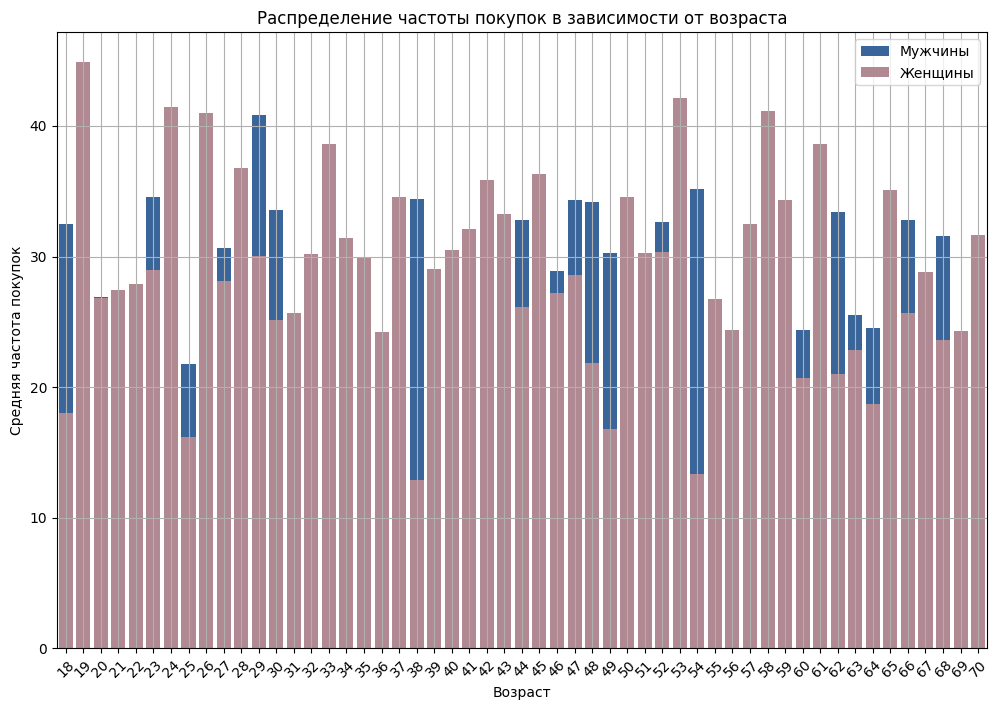

In [19]:
# Частота покупок в зависимости от возраста для каждого пола
age_frequency_counts_men = data_men.groupby('Age')['Frequency of Purchases'].mean()
age_frequency_counts_women = data_women.groupby('Age')['Frequency of Purchases'].mean()

plt.figure(figsize=(12, 8))
sns.barplot(x=age_frequency_counts_men.index, y=age_frequency_counts_men.values, label='Мужчины', color='#2964aa')
sns.barplot(x=age_frequency_counts_women.index, y=age_frequency_counts_women.values, label='Женщины', color='#b6838f')
plt.title('Распределение частоты покупок в зависимости от возраста')
plt.xlabel('Возраст')
plt.ylabel('Средняя частота покупок')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [20]:
# 3.3 покупатели самых дорогих товаров

print(data['Item Purchased'].nunique())
# топ-10 товаров по цене (удаляю дубликаты пар товар-цена)
top_10_items = data[['Item Purchased', 'Purchase Amount (USD)']].drop_duplicates().sort_values(by='Purchase Amount (USD)', ascending=False).head(10)
print(top_10_items)

25
     Item Purchased  Purchase Amount (USD)
1208          Boots                    100
42             Coat                    100
769           Socks                    100
1412         Shorts                    100
1300        T-shirt                    100
861           Skirt                    100
455          Blouse                    100
2071         Jacket                    100
3265     Sunglasses                    100
2971        Handbag                    100


In [21]:
# фильтрация данных
top_10_item_names = top_10_items['Item Purchased'].tolist()
filtered_data = data[data['Item Purchased'].isin(top_10_item_names)]
# группировка по полу
gender_expensive_counts = filtered_data['Gender'].value_counts()

print(f"Клиенты, которые покупают топ-10 дорогих товаров:")
print(gender_expensive_counts)

Клиенты, которые покупают топ-10 дорогих товаров:
Gender
Male      1042
Female     532
Name: count, dtype: int64


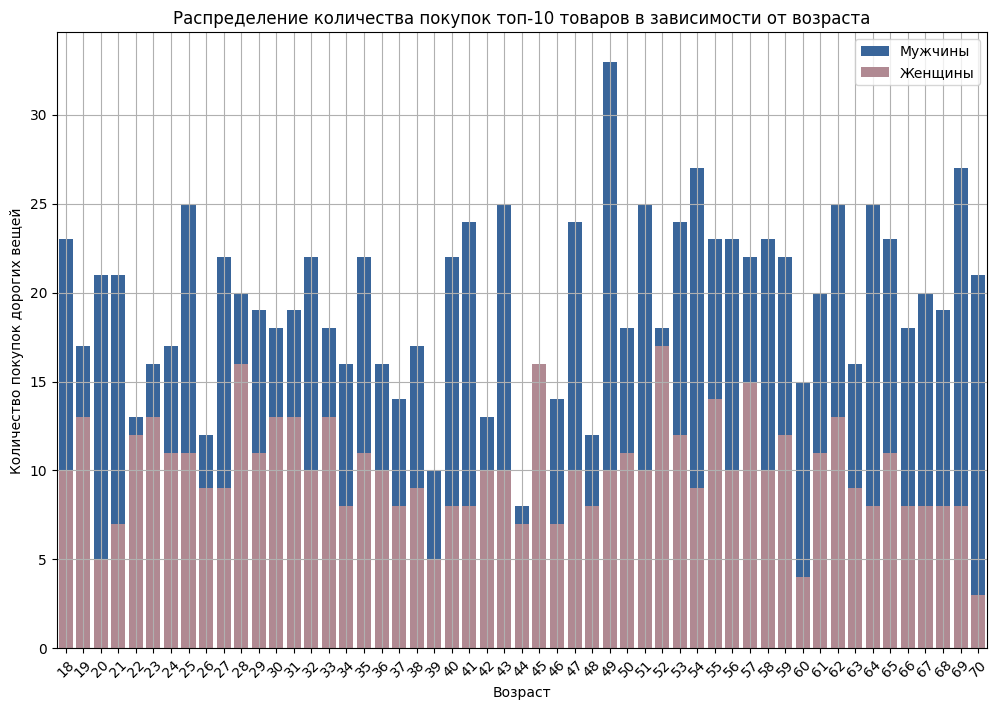

In [22]:
# зависимость покупки дорогих вещей от возраста для каждого пола
filtered_data_men = filtered_data[filtered_data['Gender'] == 'Male']
filtered_data_women = filtered_data[filtered_data['Gender'] == 'Female']
age_expensive_counts_men = filtered_data_men.groupby('Age')['Item Purchased'].count()
age_expensive_counts_women = filtered_data_women.groupby('Age')['Item Purchased'].count()

plt.figure(figsize=(12, 8))
sns.barplot(x=age_expensive_counts_men.index, y=age_expensive_counts_men.values, label='Мужчины', color='#2964aa')
sns.barplot(x=age_expensive_counts_women.index, y=age_expensive_counts_women.values, label='Женщины', color='#b6838f')
plt.title('Распределение количества покупок топ-10 товаров в зависимости от возраста')
plt.xlabel('Возраст')
plt.ylabel('Количество покупок дорогих вещей')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.show()

4. Зависимость между цветом одежды и сезоном.

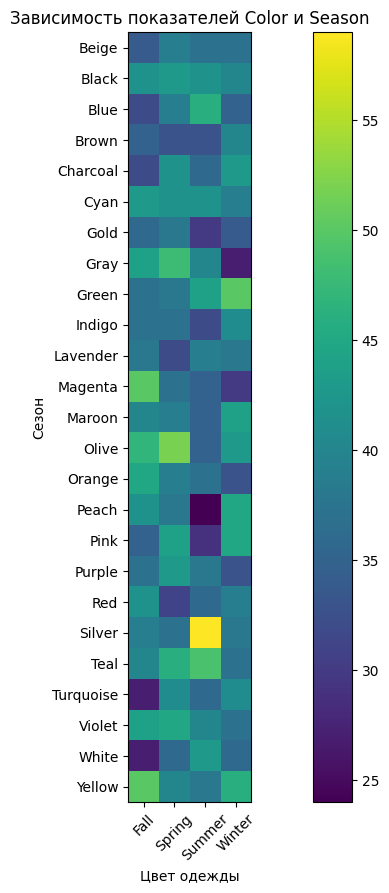

In [23]:
# таблица сопряженности
table = pd.crosstab(data['Color'], data['Season'])
plt.figure(figsize=(16, 10))
plt.imshow(table)
plt.title('Зависимость показателей Color и Season')
plt.xlabel('Цвет одежды')
plt.ylabel('Сезон')
plt.xticks(range(len(table.columns)), table.columns)
plt.yticks(range(len(table.index)), table.index)
plt.xticks(rotation=45)
plt.colorbar()
plt.show()

5. Расчёт сезонного mau (уникальных пользователей за сезон) и его динамики.

   Season  MAU
3  Winter  971
1  Spring  999
2  Summer  955
0    Fall  975


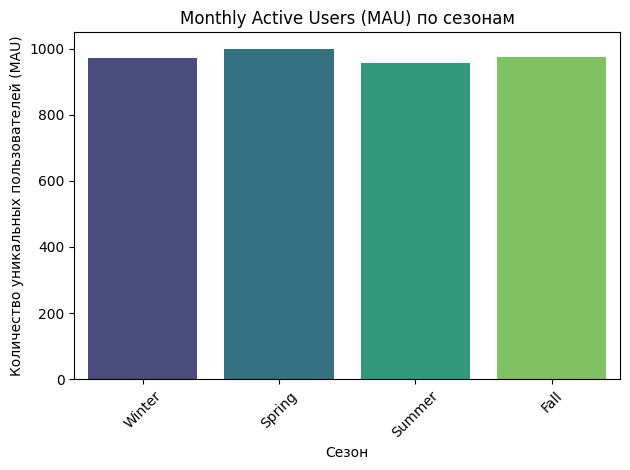

In [24]:
seasons = {'Winter': 0, 'Spring': 1, 'Summer': 2, 'Fall': 3}
data['Season_order'] = data['Season'].map(seasons)

# группировка данных по сезону и подсчёт уникальных пользователей
seasonal_mau = data.groupby('Season')['Customer ID'].nunique().reset_index(name='MAU')

# столбец с порядком сезонов для сортировки
seasonal_mau['Season_order'] = seasonal_mau['Season'].map(seasons)
seasonal_mau = seasonal_mau.sort_values(by='Season_order')

print(seasonal_mau[['Season', 'MAU']])

sns.barplot(x='Season', y='MAU', data=seasonal_mau, palette='viridis')
plt.title('Monthly Active Users (MAU) по сезонам')
plt.xlabel('Сезон')
plt.ylabel('Количество уникальных пользователей (MAU)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


6. Самая популярная буква в названии одежды.

In [25]:
# сбор всех названий одежды в одну строку 
all_items = ''.join(data['Item Purchased'].dropna().astype(str).values)
all_items = all_items.lower() # не учитываю регистр 
# удаление небуквенных символов 
all_items = ''.join(filter(lambda x: x in string.ascii_lowercase, all_items))

# самая популярная буква
letter_counts = Counter(all_items)
most_common_letter, count = letter_counts.most_common(1)[0]

print(f'Самая популярная буква: "{most_common_letter}"')
print(f'Встречается {count} раз(а)')

Самая популярная буква: "s"
Встречается 4063 раз(а)


<h1>Задание 2</h1> 

У нас есть данные о потреблении алкоголя в мире https://github.com/fivethirtyeight/data/tree/master/alcohol-consumption. 

Загрузите их и изучите, где же люди пьют больше вина, пива и других спиртных напитков.

Показатели:
1. country;
2. beer_servings - порция пива;
3. spirit_servings - порция спирта;
4. wine_servings - порция вина;
5. total_litres_of_pure_alcohol - количество литров чистого спирта.

In [26]:
data_2 = pd.read_csv('drinks.csv')
data_2.head()

,country,beer_servings,spirit_servings,wine_servings,total_litres_of_pure_alcohol
0,Afghanistan,0,0,0,0.0
1,Albania,89,132,54,4.9
2,Algeria,25,0,14,0.7
3,Andorra,245,138,312,12.4
4,Angola,217,57,45,5.9


In [27]:
data_2.describe()

,beer_servings,spirit_servings,wine_servings,total_litres_of_pure_alcohol
count,193.000000,193.000000,193.000000,193.000000
mean,106.160622,80.994819,49.450777,4.717098
std,101.143103,88.284312,79.697598,3.773298
min,0.000000,0.000000,0.000000,0.000000
25%,20.000000,4.000000,1.000000,1.300000
50%,76.000000,56.000000,8.000000,4.200000
75%,188.000000,128.000000,59.000000,7.200000
max,376.000000,438.000000,370.000000,14.400000


In [28]:
data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193 entries, 0 to 192
Data columns (total 5 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   country                       193 non-null    object 
 1   beer_servings                 193 non-null    int64  
 2   spirit_servings               193 non-null    int64  
 3   wine_servings                 193 non-null    int64  
 4   total_litres_of_pure_alcohol  193 non-null    float64
dtypes: float64(1), int64(3), object(1)
memory usage: 7.7+ KB


In [29]:
print(data_2['country'].nunique())

193


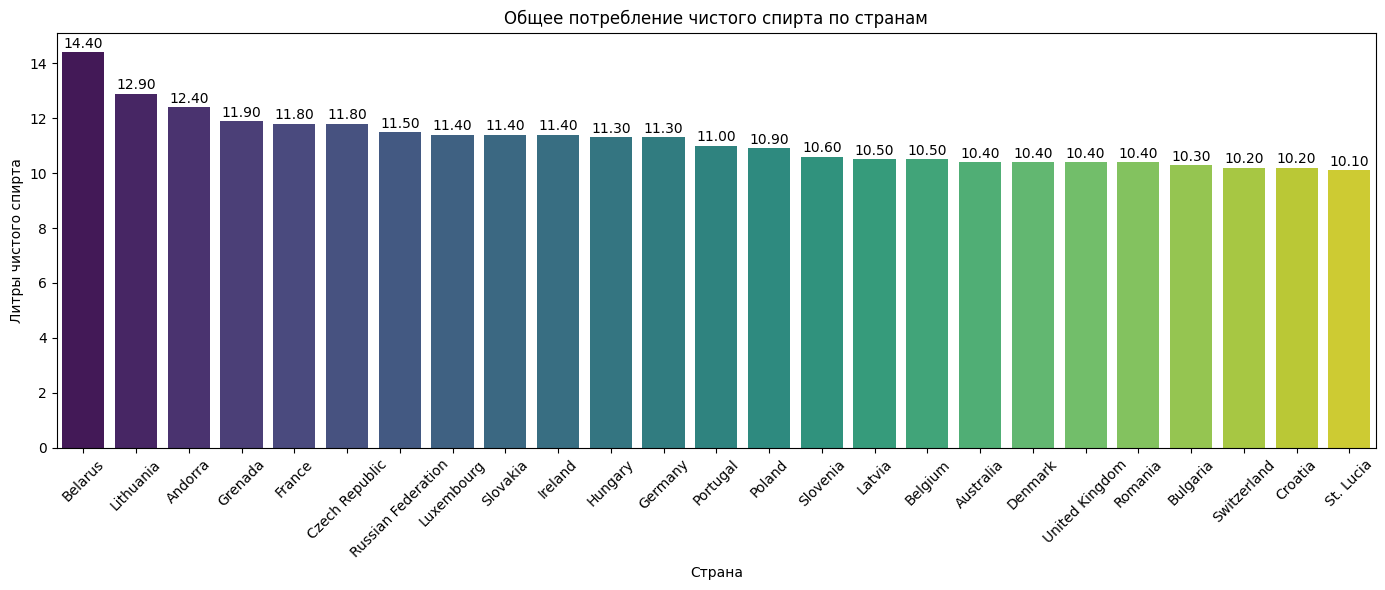

In [30]:
# количество употребляемого чистого спирта для стран

# сортировка по количеству литров чистого спирта; первые 25 стран
sorted_data = data_2[['country', 'total_litres_of_pure_alcohol']].sort_values(by='total_litres_of_pure_alcohol', ascending=False).head(25)

plt.figure(figsize=(14, 6))
sns.barplot(x='country', y='total_litres_of_pure_alcohol', data=sorted_data, palette='viridis')
for i, value in enumerate(sorted_data['total_litres_of_pure_alcohol']):
    plt.text(i, value + 0.05, f'{value:.2f}', ha='center', va='bottom', fontsize=10)
plt.title('Общее потребление чистого спирта по странам')
plt.xlabel('Страна')
plt.ylabel('Литры чистого спирта')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

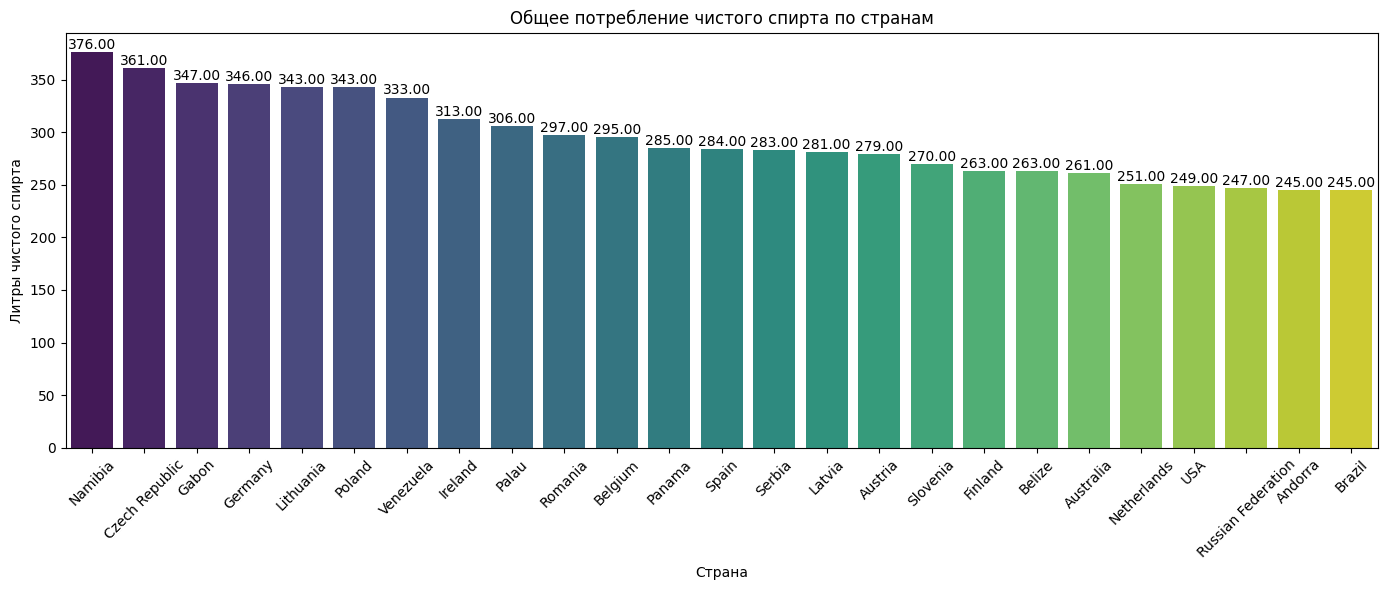

In [31]:
# количество порций пива

# сортировка по количеству лпорций пива; первые 25 стран
sorted_data = data_2[['country', 'beer_servings']].sort_values(by='beer_servings', ascending=False).head(25)

plt.figure(figsize=(14, 6))
sns.barplot(x='country', y='beer_servings', data=sorted_data, palette='viridis')
for i, value in enumerate(sorted_data['beer_servings']):
    plt.text(i, value + 0.05, f'{value:.2f}', ha='center', va='bottom', fontsize=10)
plt.title('Общее потребление чистого спирта по странам')
plt.xlabel('Страна')
plt.ylabel('Литры чистого спирта')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

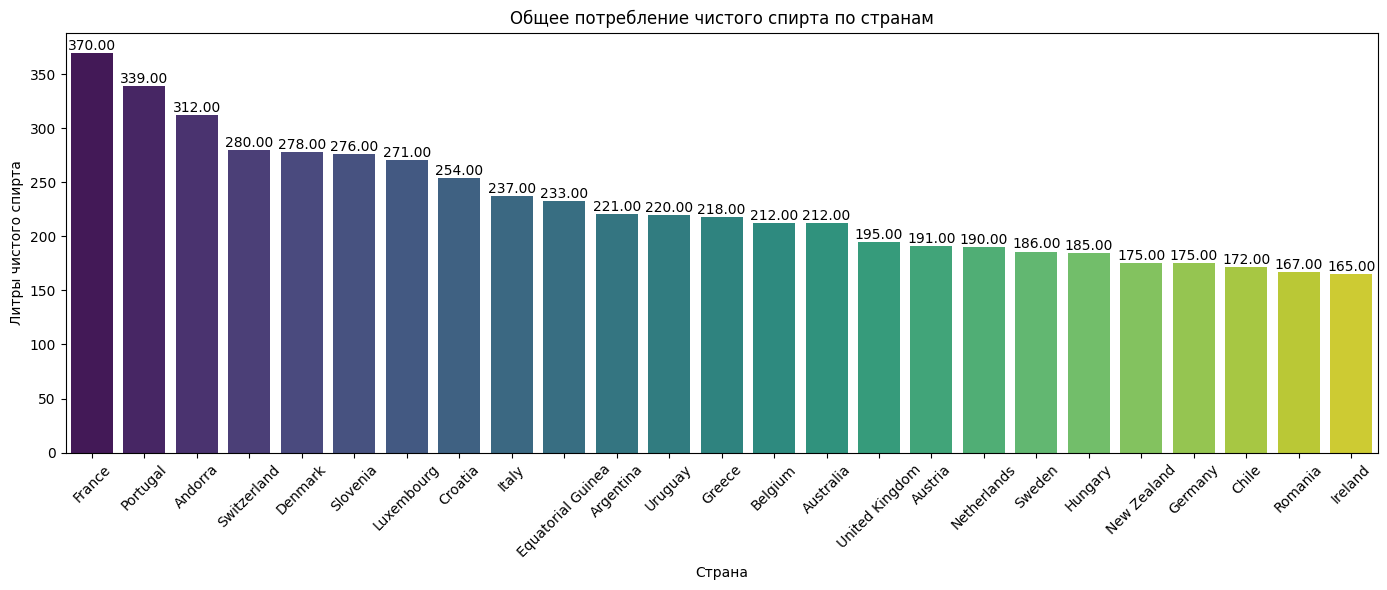

In [32]:
# количество порций вина
sorted_data = data_2[['country', 'wine_servings']].sort_values(by='wine_servings', ascending=False).head(25)

plt.figure(figsize=(14, 6))
sns.barplot(x='country', y='wine_servings', data=sorted_data, palette='viridis')
for i, value in enumerate(sorted_data['wine_servings']):
    plt.text(i, value + 0.05, f'{value:.2f}', ha='center', va='bottom', fontsize=10)
plt.title('Общее потребление чистого спирта по странам')
plt.xlabel('Страна')
plt.ylabel('Литры чистого спирта')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

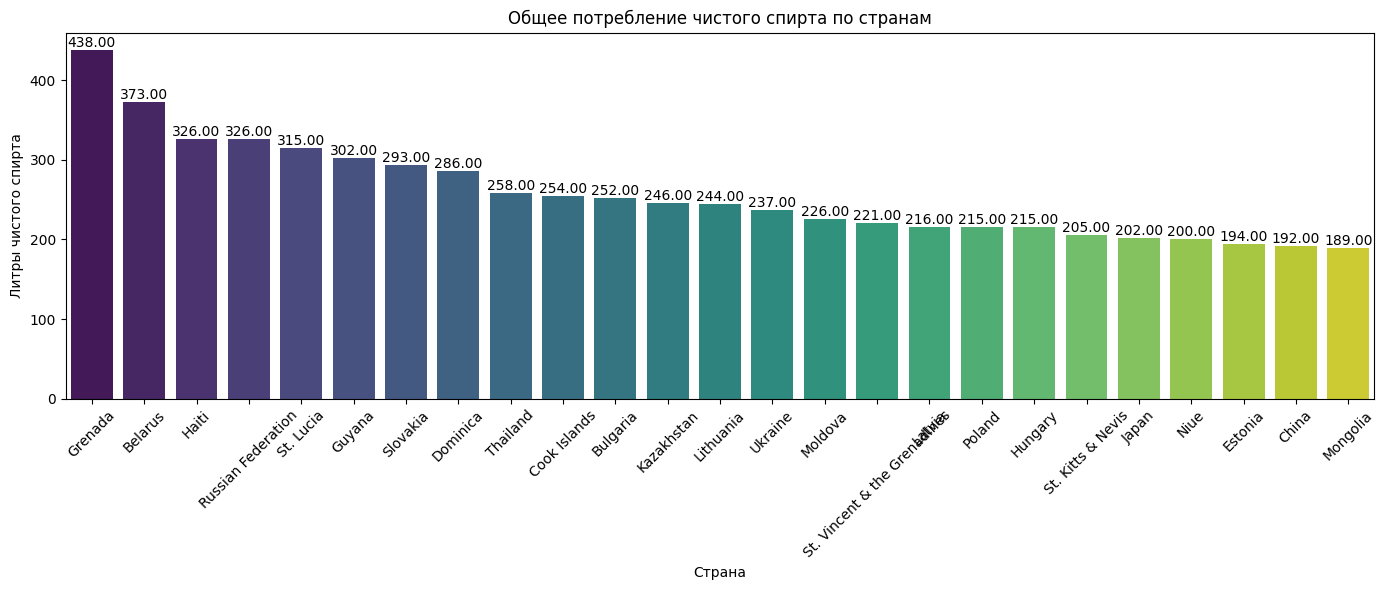

In [33]:
# количество порций спирта
sorted_data = data_2[['country', 'spirit_servings']].sort_values(by='spirit_servings', ascending=False).head(25)

plt.figure(figsize=(14, 6))
sns.barplot(x='country', y='spirit_servings', data=sorted_data, palette='viridis')
for i, value in enumerate(sorted_data['spirit_servings']):
    plt.text(i, value + 0.05, f'{value:.2f}', ha='center', va='bottom', fontsize=10)
plt.title('Общее потребление чистого спирта по странам')
plt.xlabel('Страна')
plt.ylabel('Литры чистого спирта')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<h1>Задание 3</h1> 

У нас есть полный каталог всех случаев, когда кто-то проклинал или истекал кровью в фильме Квентина Тарантино. https://github.com/fivethirtyeight/data/tree/master/tarantino

Определите:

* число проклятий, летальных исходов и их соотношение по фильмам 

* частоту употребления конкретных проклятий 

* распределение времени между проклятиями 

Показатели:

1. movie - название фильма;

2. type	- было ли событие ругательством или смертью

3. word	- конкретное нецензурное слово, если событие было словом;

4. minutes_in - количество минут после начала фильма, когда произошло событие.

In [34]:
data_3 = pd.read_csv('tarantino.csv')
data_3.head()

,movie,type,word,minutes_in
0,Reservoir Dogs,word,dick,0.40
1,Reservoir Dogs,word,dicks,0.43
2,Reservoir Dogs,word,fucked,0.55
3,Reservoir Dogs,word,fucking,0.61
4,Reservoir Dogs,word,bullshit,0.61


In [35]:
data_3.info()
# --> пустые значения в столбце word - записи о смерти :(

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1894 entries, 0 to 1893
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   movie       1894 non-null   object 
 1   type        1894 non-null   object 
 2   word        1704 non-null   object 
 3   minutes_in  1894 non-null   float64
dtypes: float64(1), object(3)
memory usage: 59.3+ KB


1. Подсчёт числа проклятий (слов), смертей и их отношения для каждого фильма.

Общее количество смертей:  190


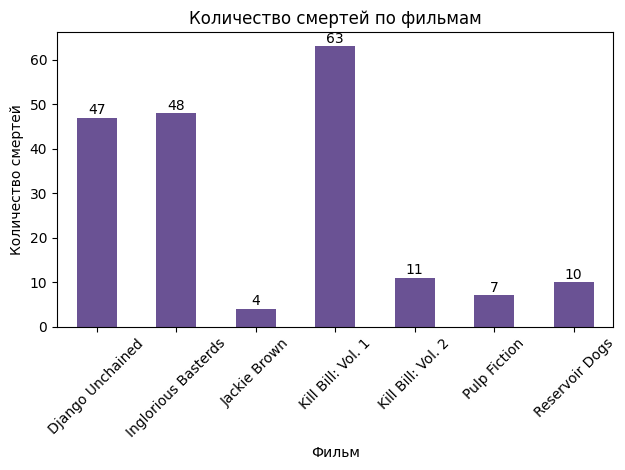

In [36]:
# только смерти персонажей
deaths = data_3[data_3['type'] == 'death']
print('Общее количество смертей: ', len(deaths))

# группировка по фильмам
death_counts = deaths.groupby('movie').size()

death_counts.plot(kind='bar', color='#6a5294')
ax = death_counts.plot(kind='bar', color='#6a5294')
plt.title('Количество смертей по фильмам')
plt.xlabel('Фильм')
plt.ylabel('Количество смертей')
plt.xticks(rotation=45)
for i, v in enumerate(death_counts):
    ax.text(i, v + 0.1, str(v), ha='center', va='bottom', color='black')
plt.tight_layout()
plt.show()

Общее количество проклятий:  1704


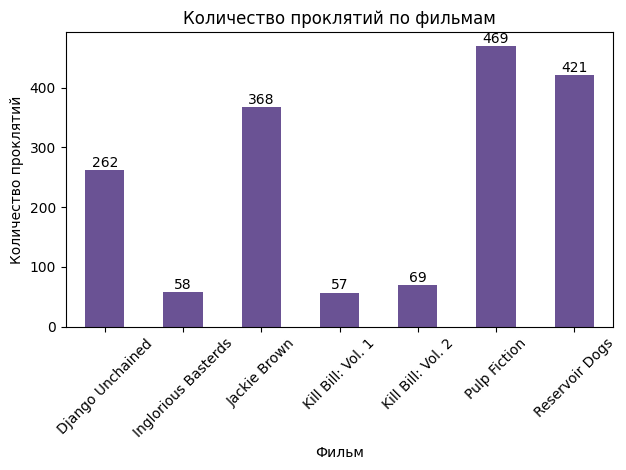

In [37]:
# только проклятия
curses = data_3[data_3['type'] == 'word']
print('Общее количество проклятий: ', len(curses))
# группировка по фильмам
word_counts = curses.groupby('movie').size()

word_counts.plot(kind='bar', color='#b6838f')
ax = word_counts.plot(kind='bar', color='#6a5294')
plt.title('Количество проклятий по фильмам')
plt.xlabel('Фильм')
plt.ylabel('Количество проклятий')
plt.xticks(rotation=45)
for i, v in enumerate(word_counts):
    ax.text(i, v + 0.1, str(v), ha='center', va='bottom', color='black')
plt.tight_layout()
plt.show()

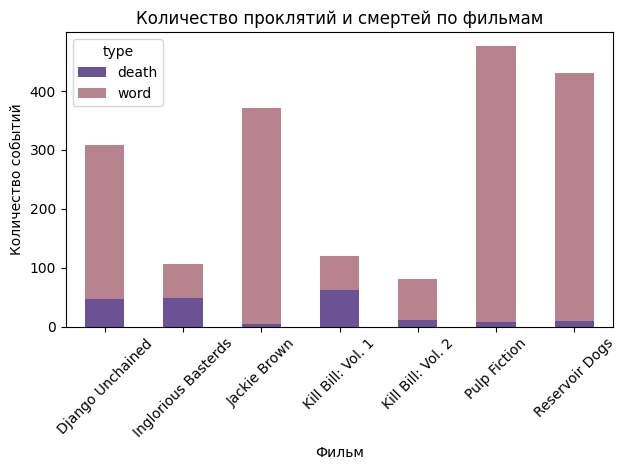

In [38]:
# группировка по фильмам и типам событий - общий график
event_counts = data_3.groupby(['movie', 'type']).size().unstack(fill_value=0)

event_counts.plot(kind='bar', stacked=True, color=['#6a5294', '#b6838f'])
plt.title('Количество проклятий и смертей по фильмам')
plt.xlabel('Фильм')
plt.ylabel('Количество событий')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

2. Частоты употребления конкретных проклятий.

Количество уникальных проклятий:  60


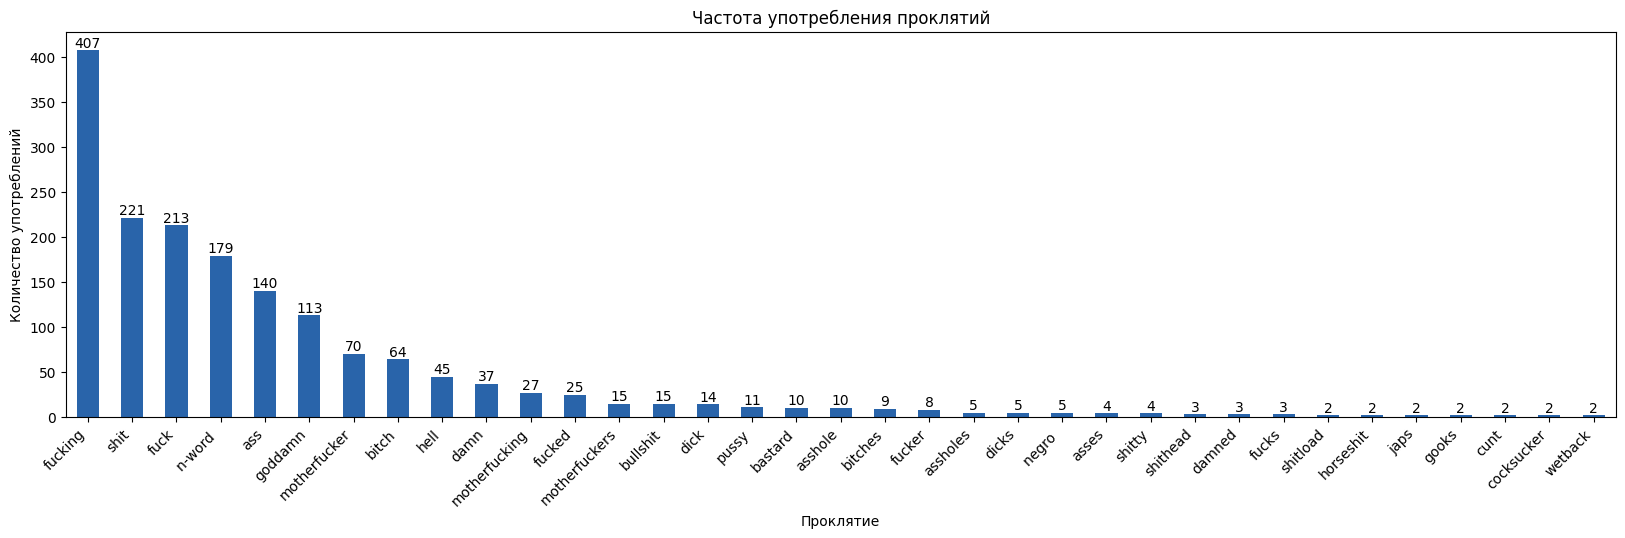

In [39]:
# группировка по словам
word_counts = curses['word'].value_counts()
print('Количество уникальных проклятий: ', len(word_counts))

# убираю редко встречающиеся слова
filtered_word_counts = word_counts[word_counts > 1]

filtered_word_counts.plot(kind='bar', color='#2964aa', figsize=(20,5))
plt.title('Частота употребления проклятий')
plt.xlabel('Проклятие')
plt.ylabel('Количество употреблений')
plt.xticks(rotation=45, ha='right')
for i, v in enumerate(filtered_word_counts):
    plt.text(i, v + 0.1, str(v), ha='center', va='bottom', color='black')
plt.show()

3. Распределение времени между проклятиями в каждом фильме.

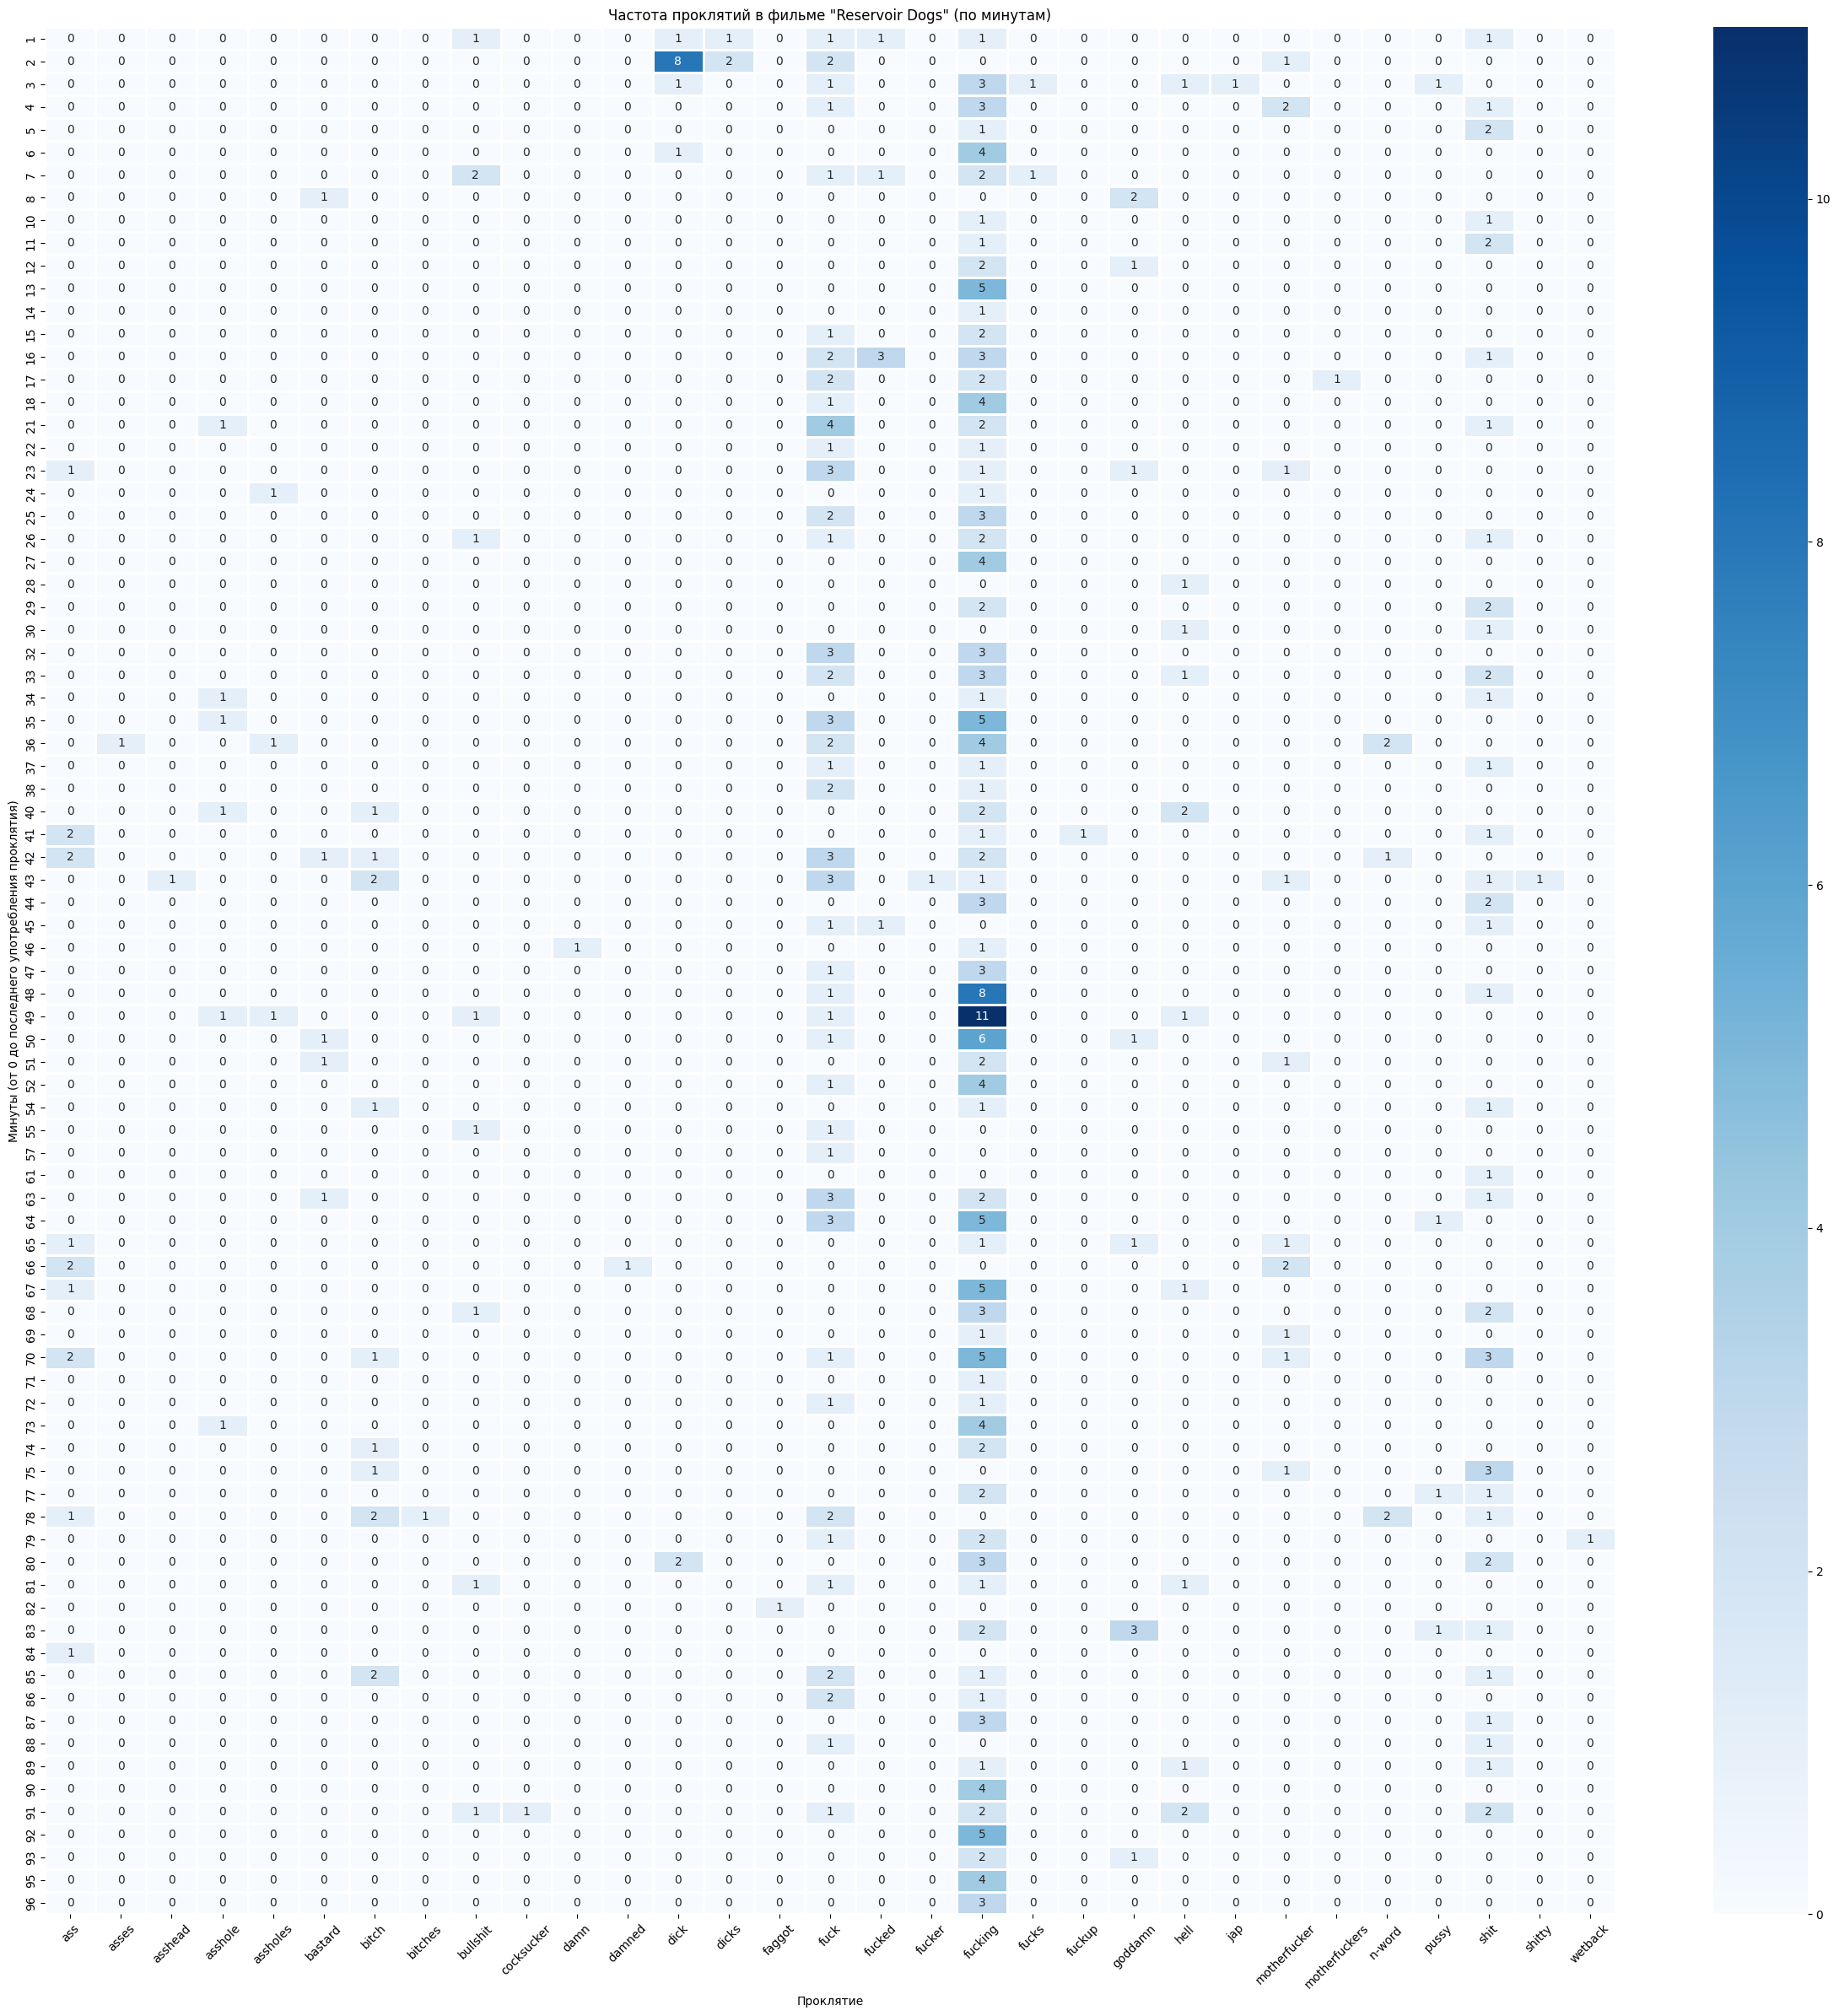

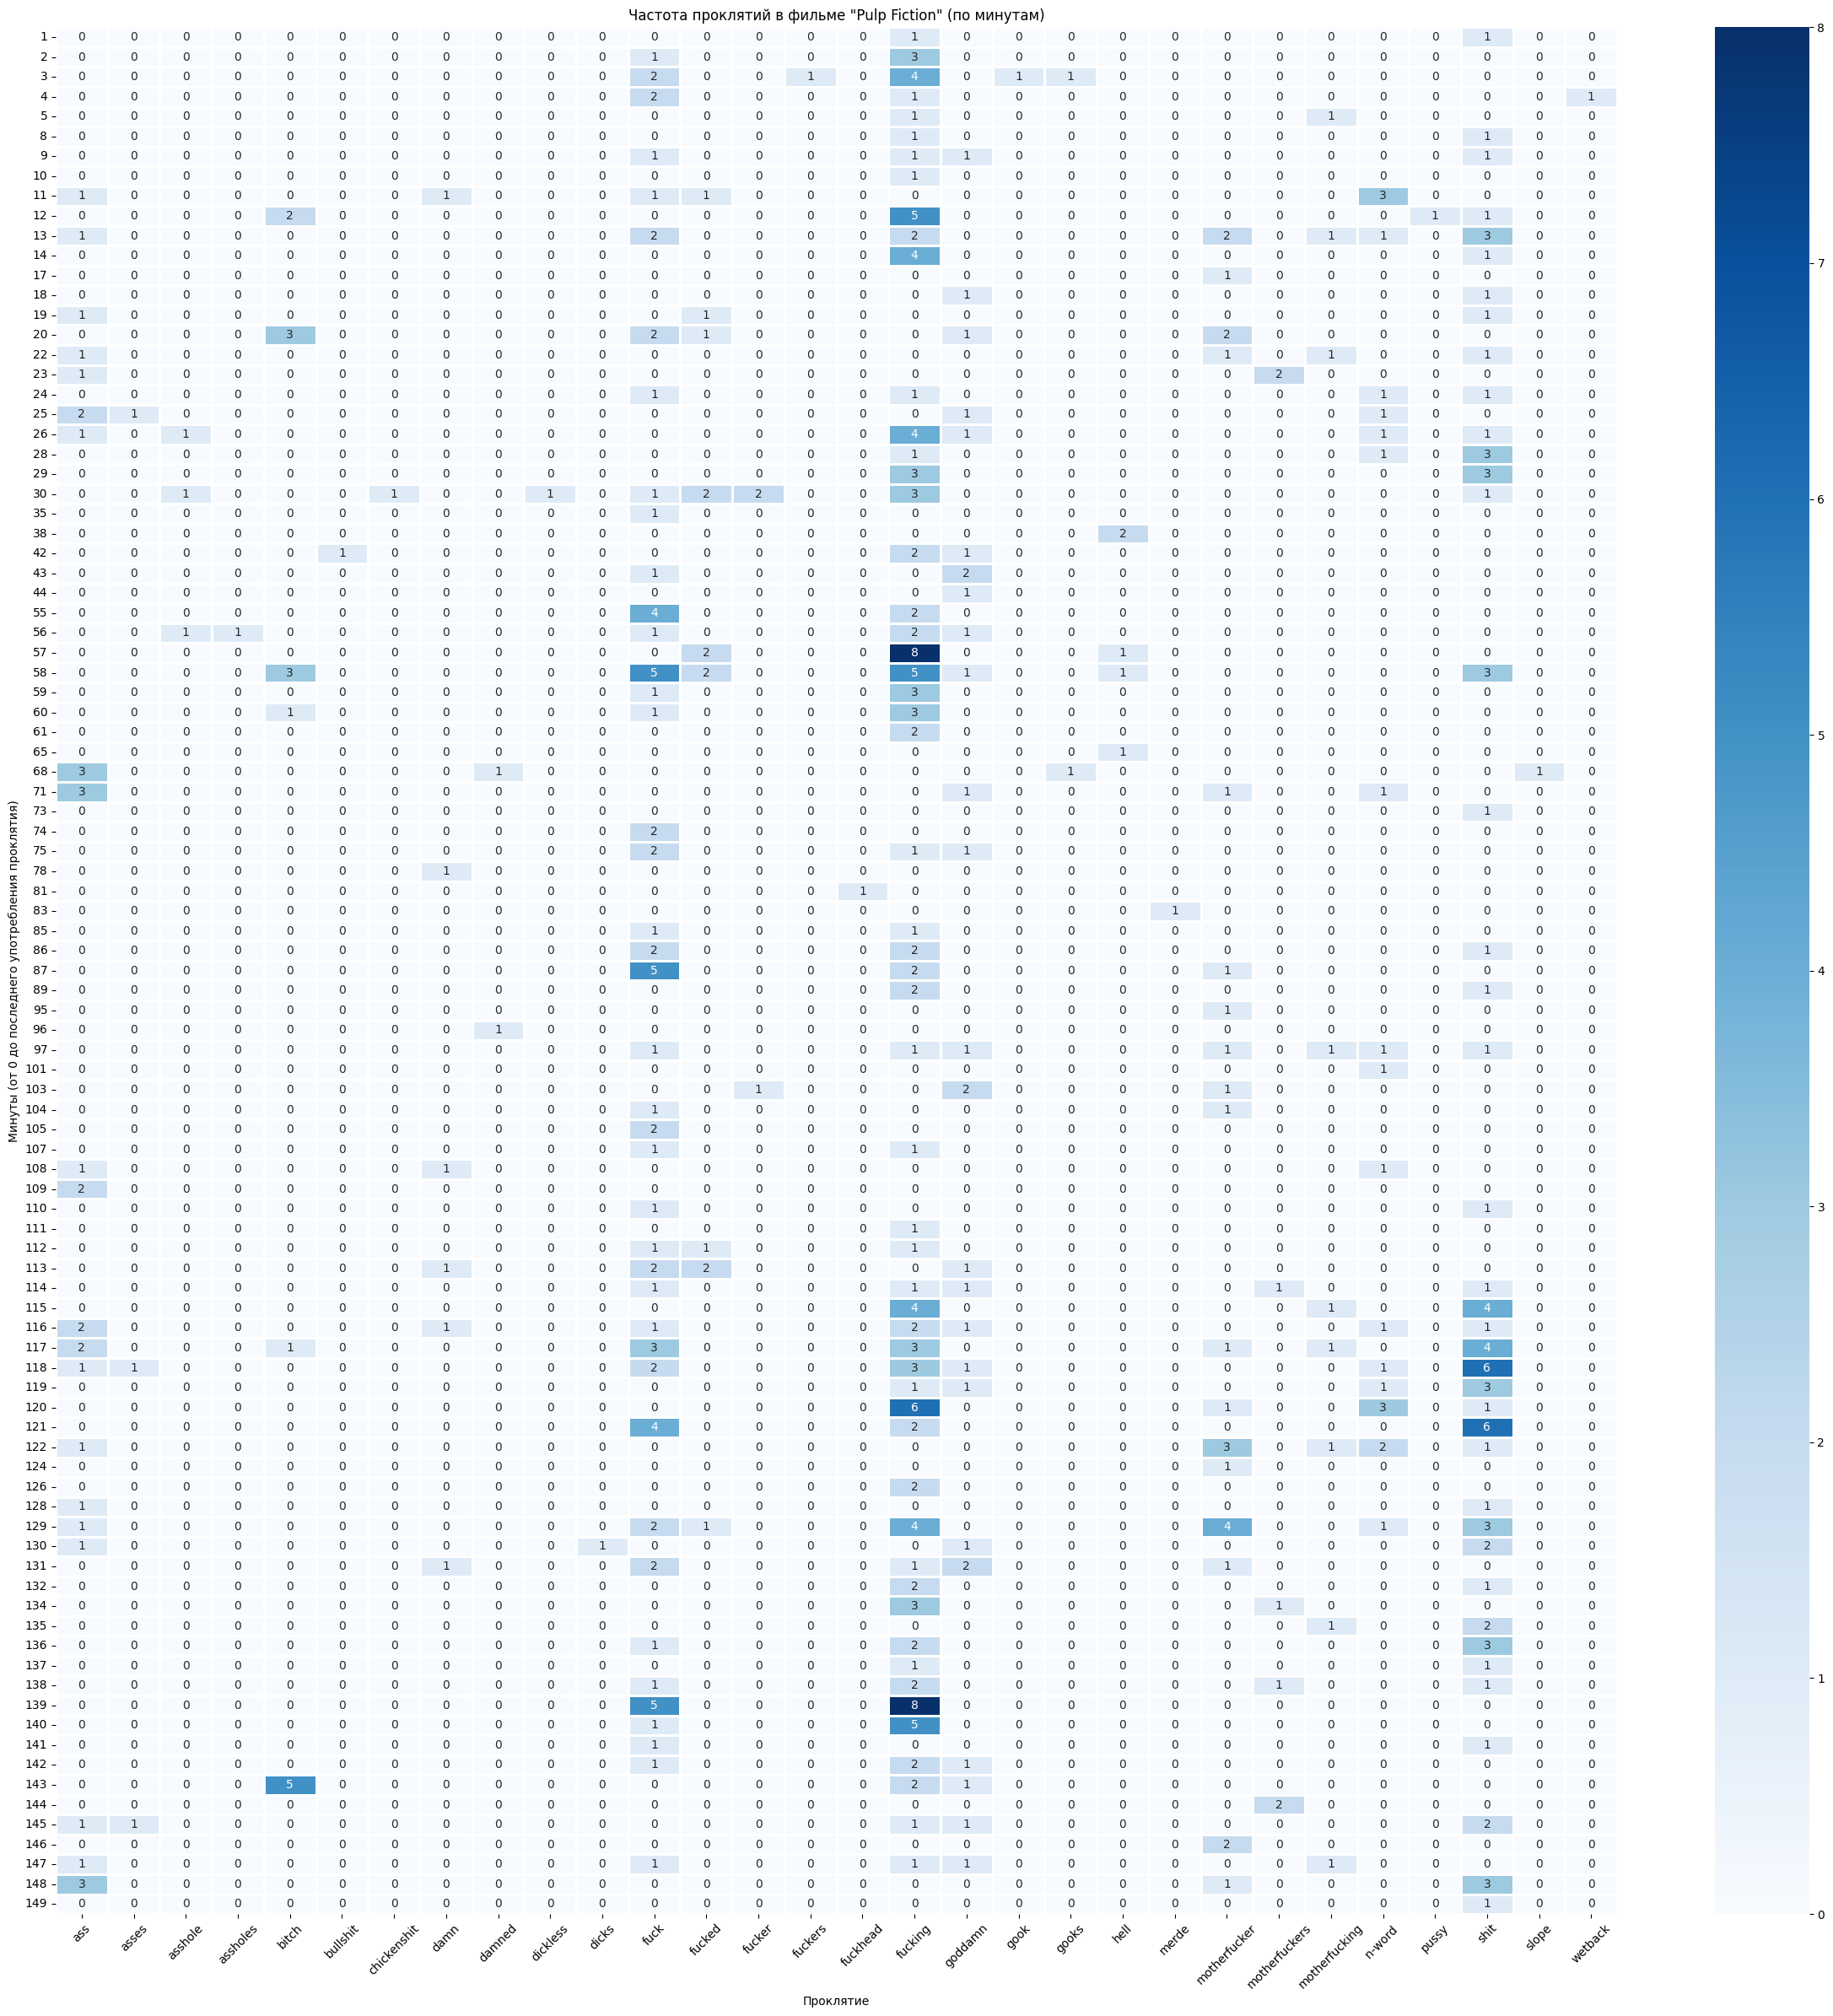

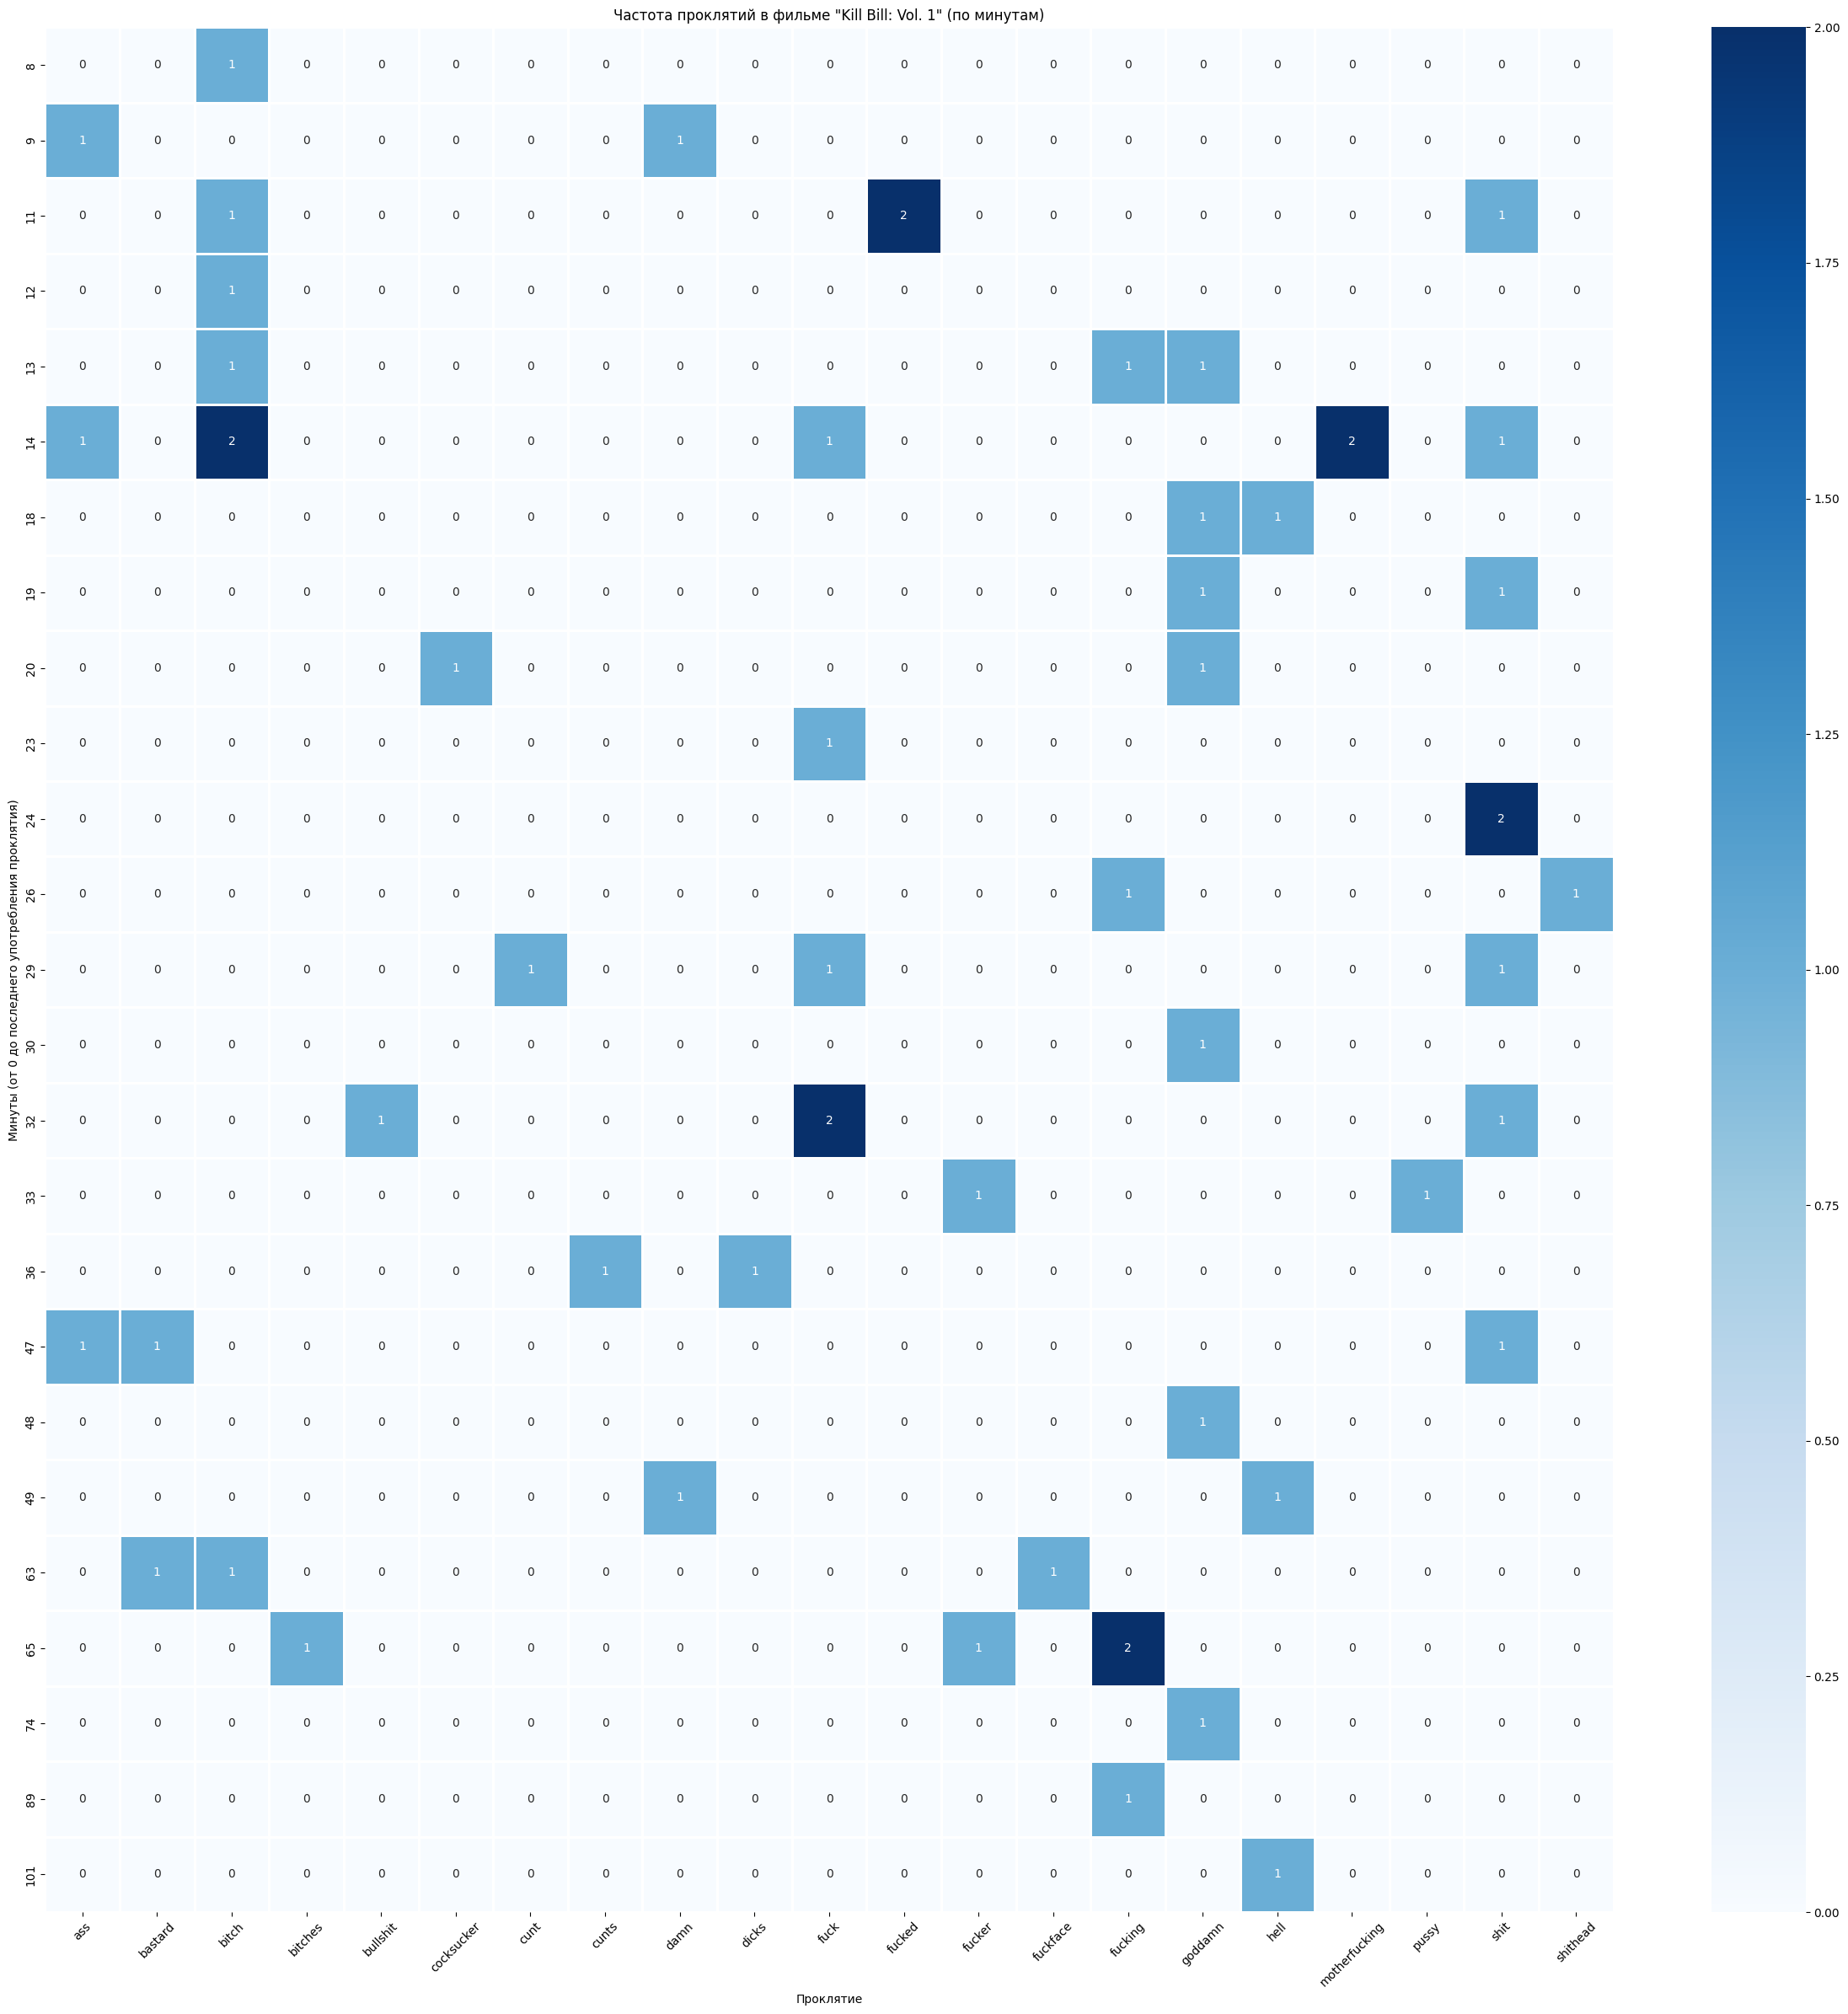

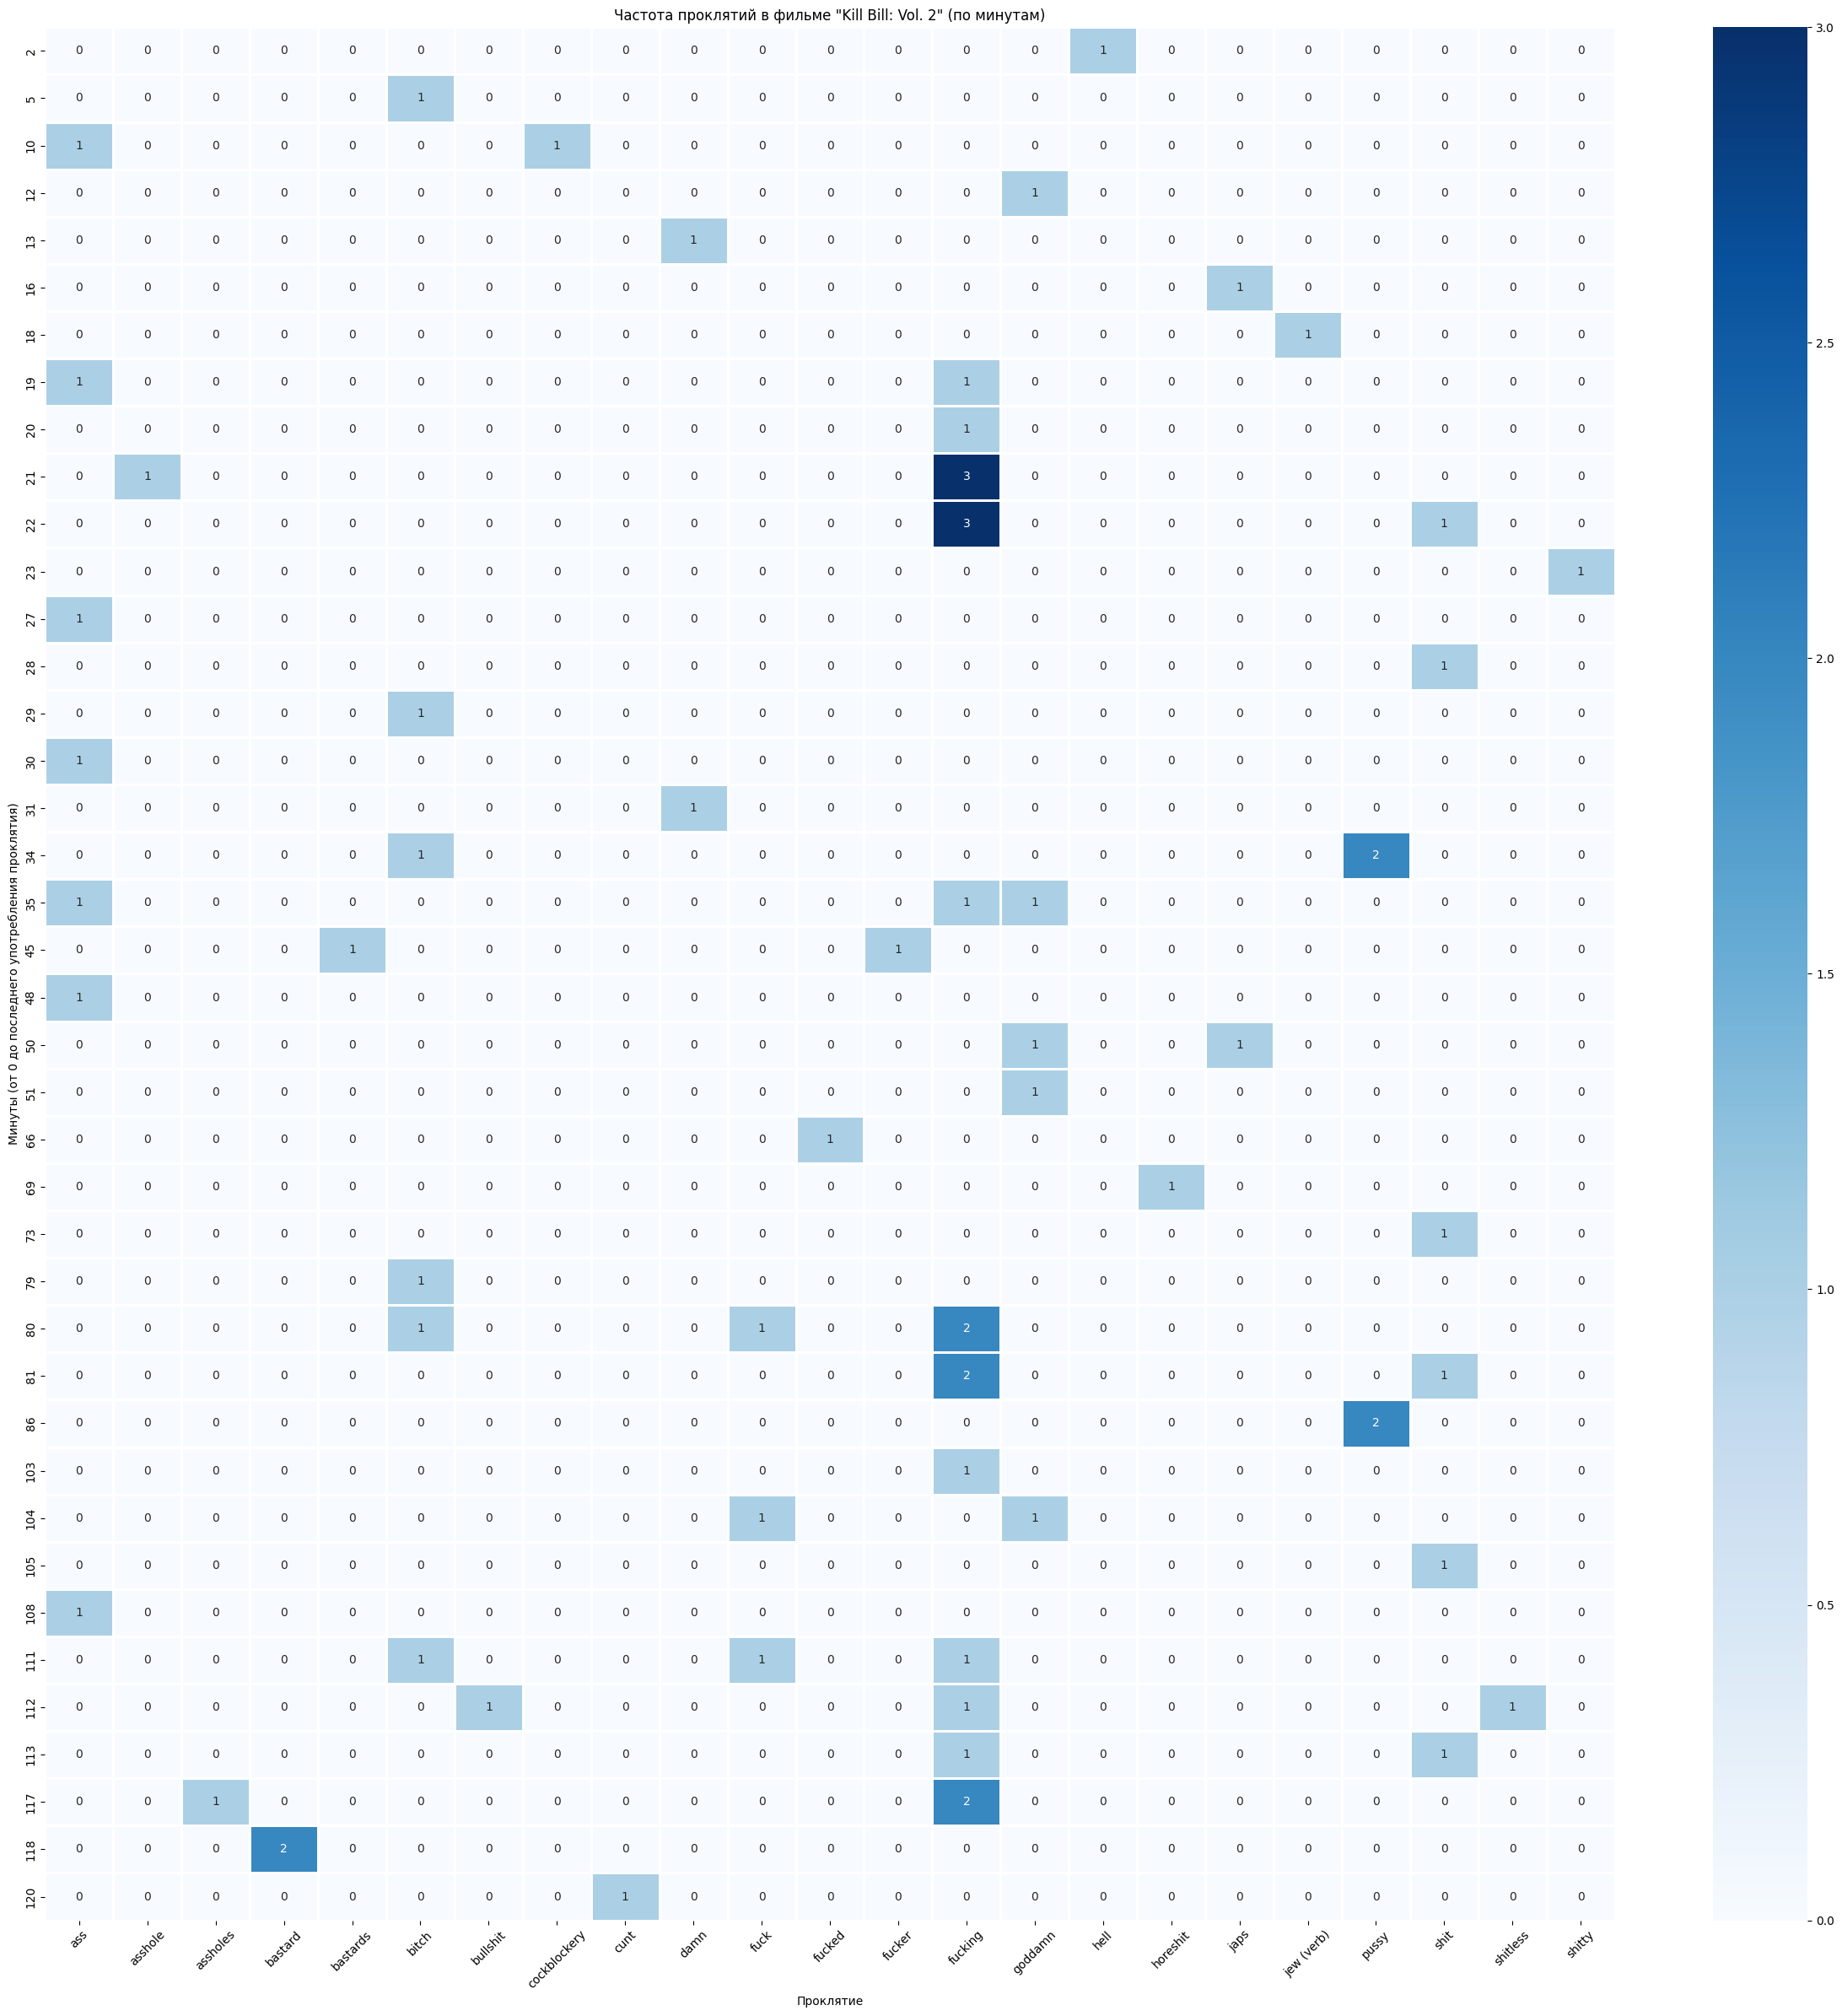

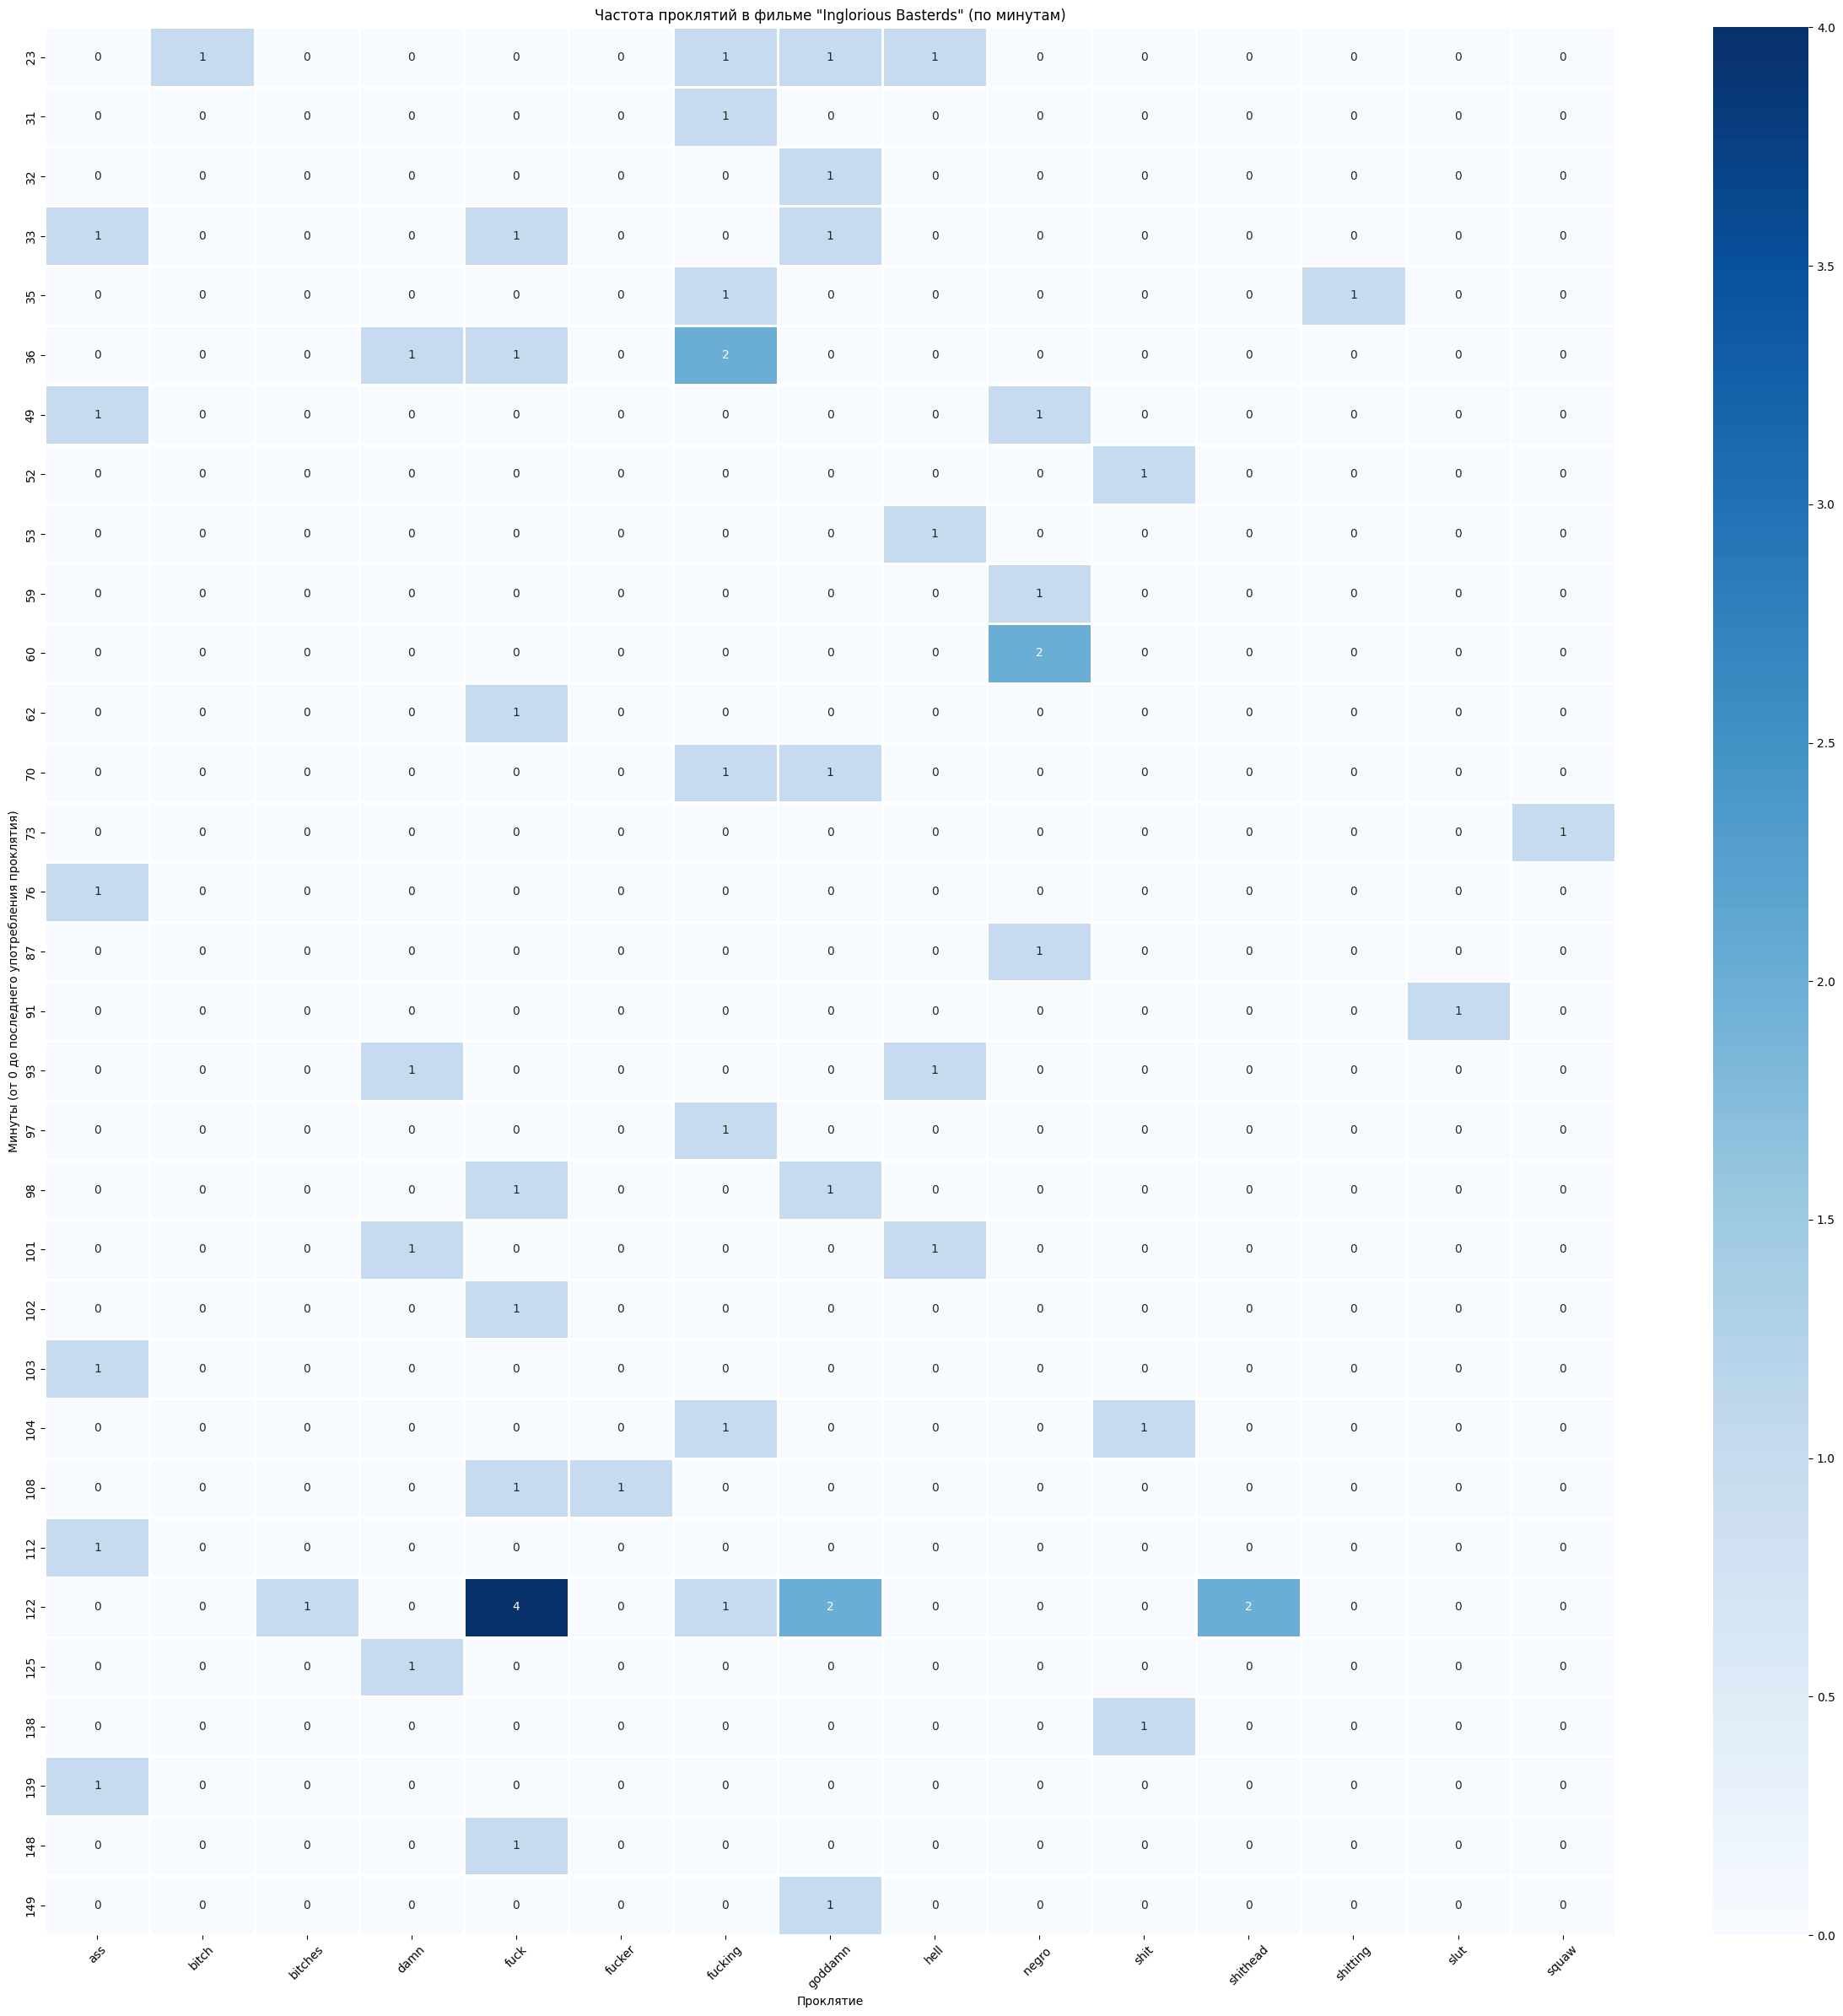

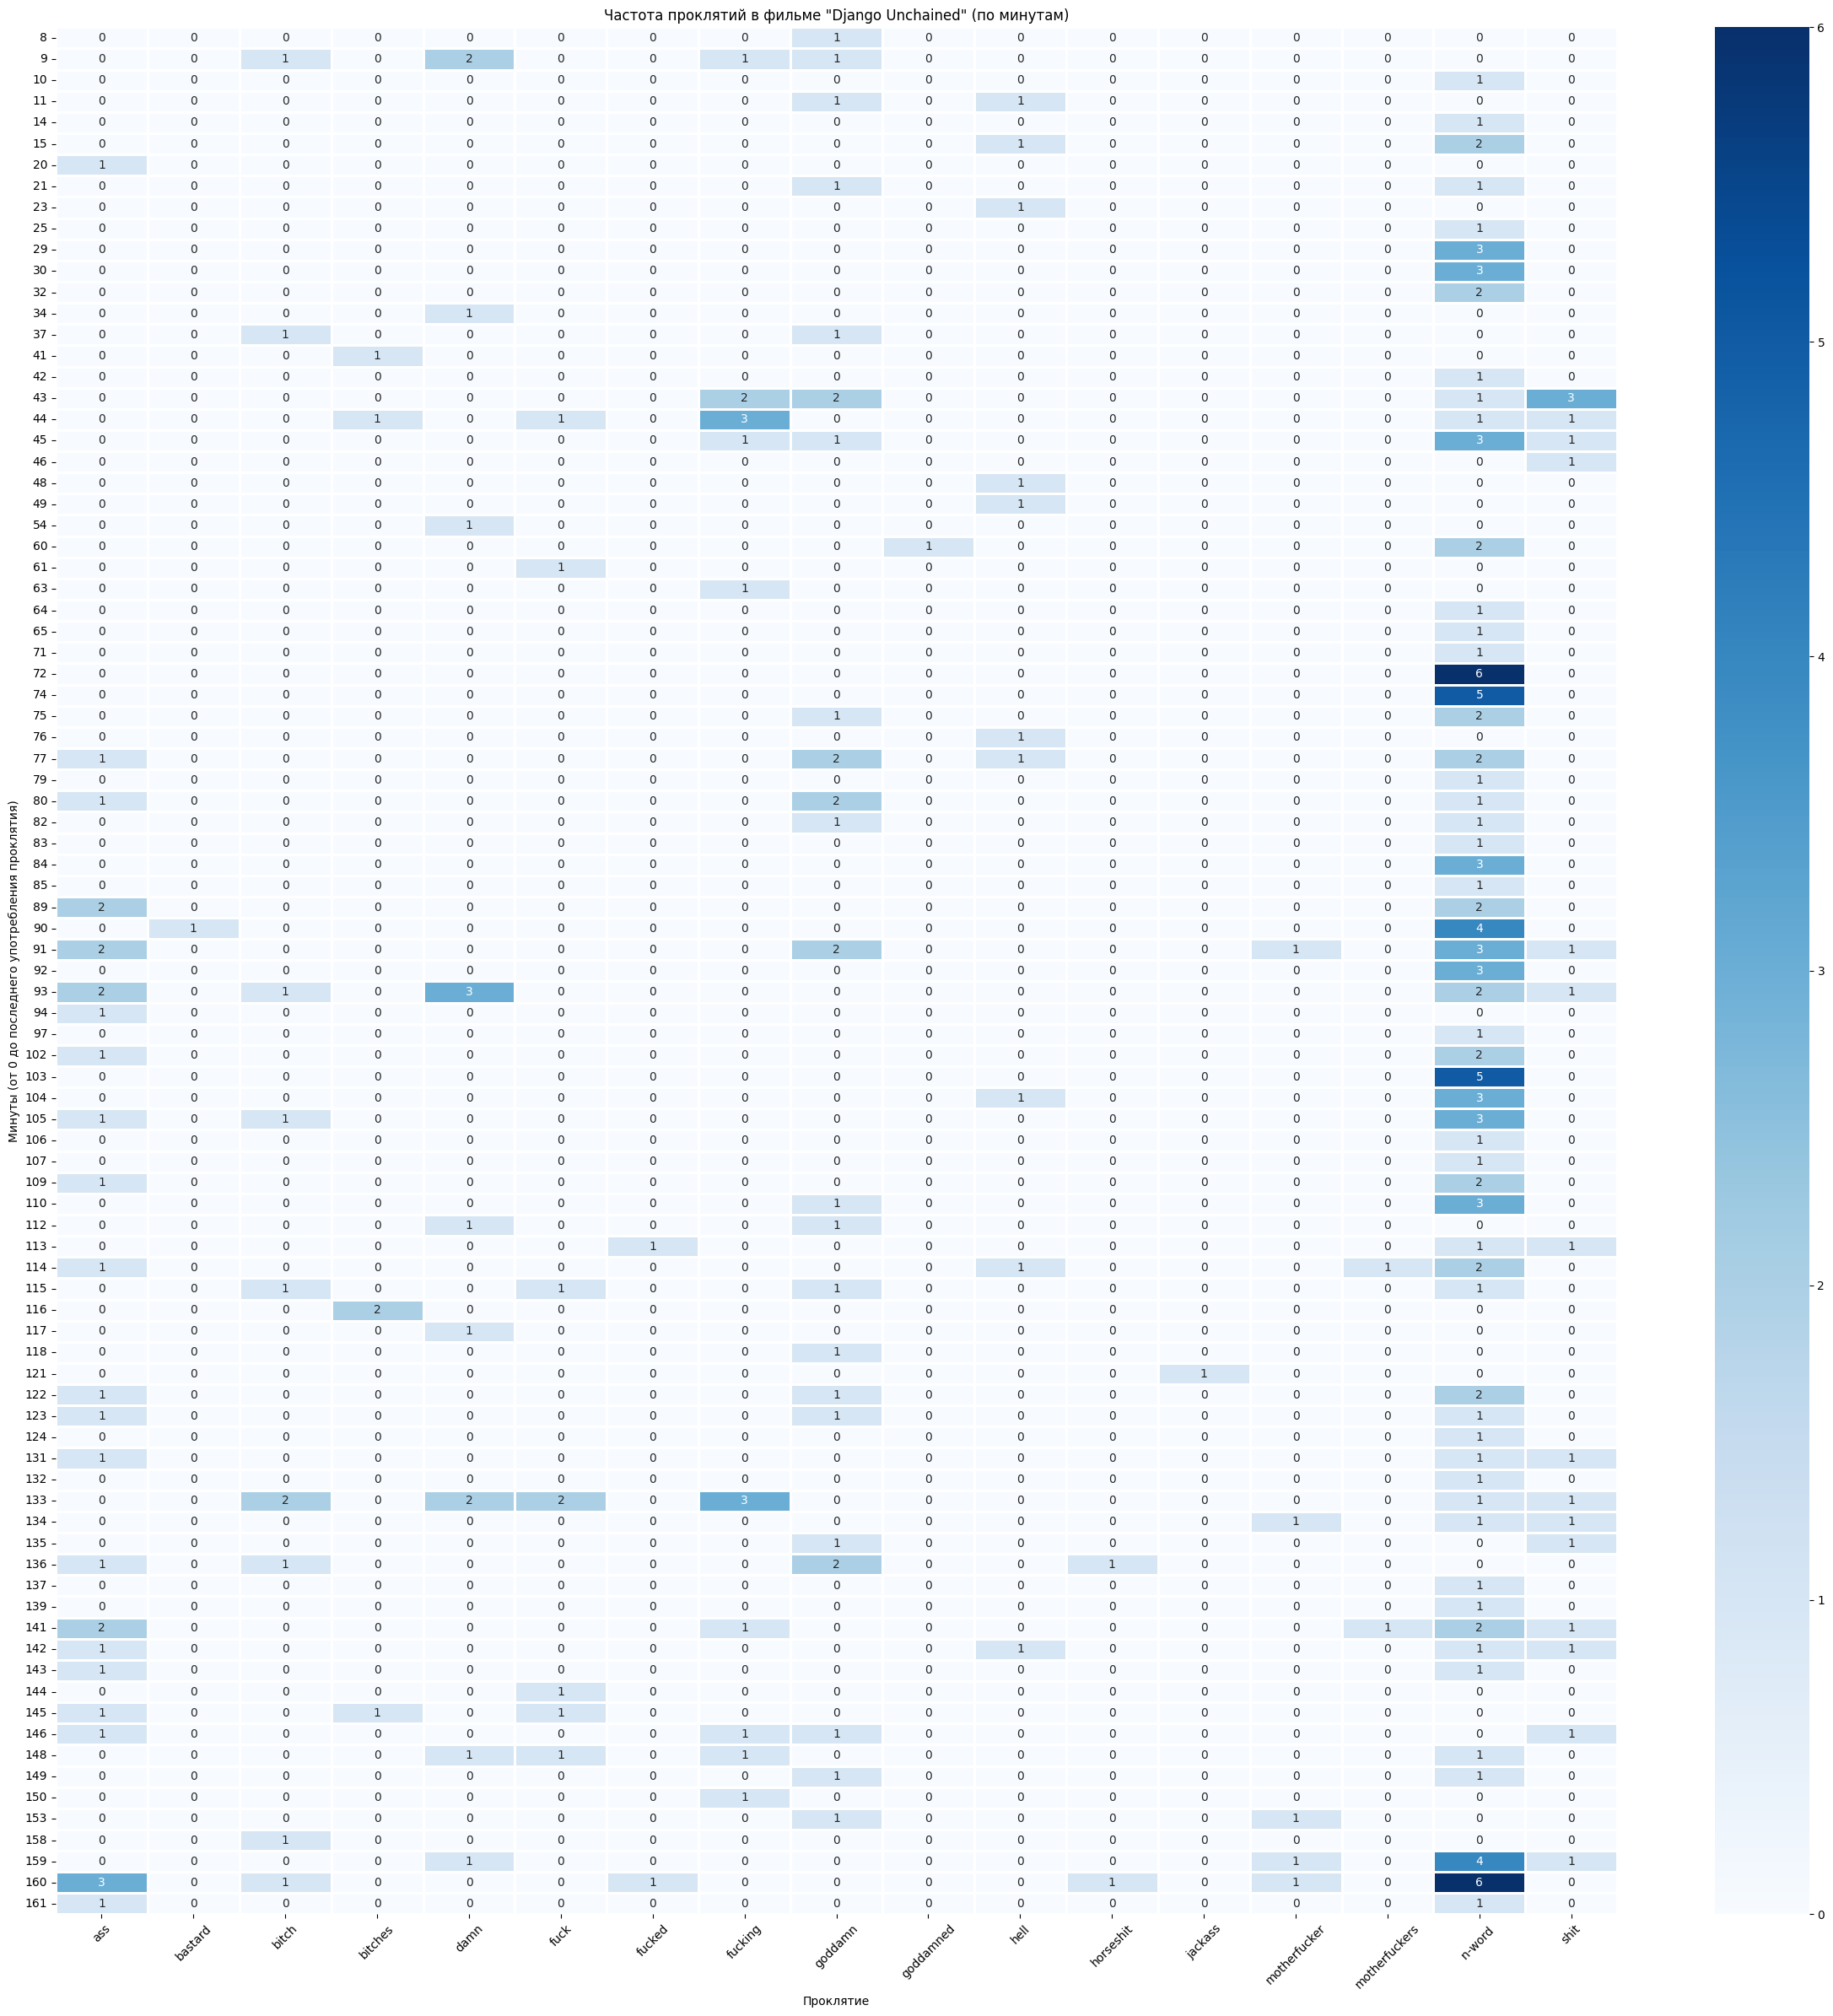

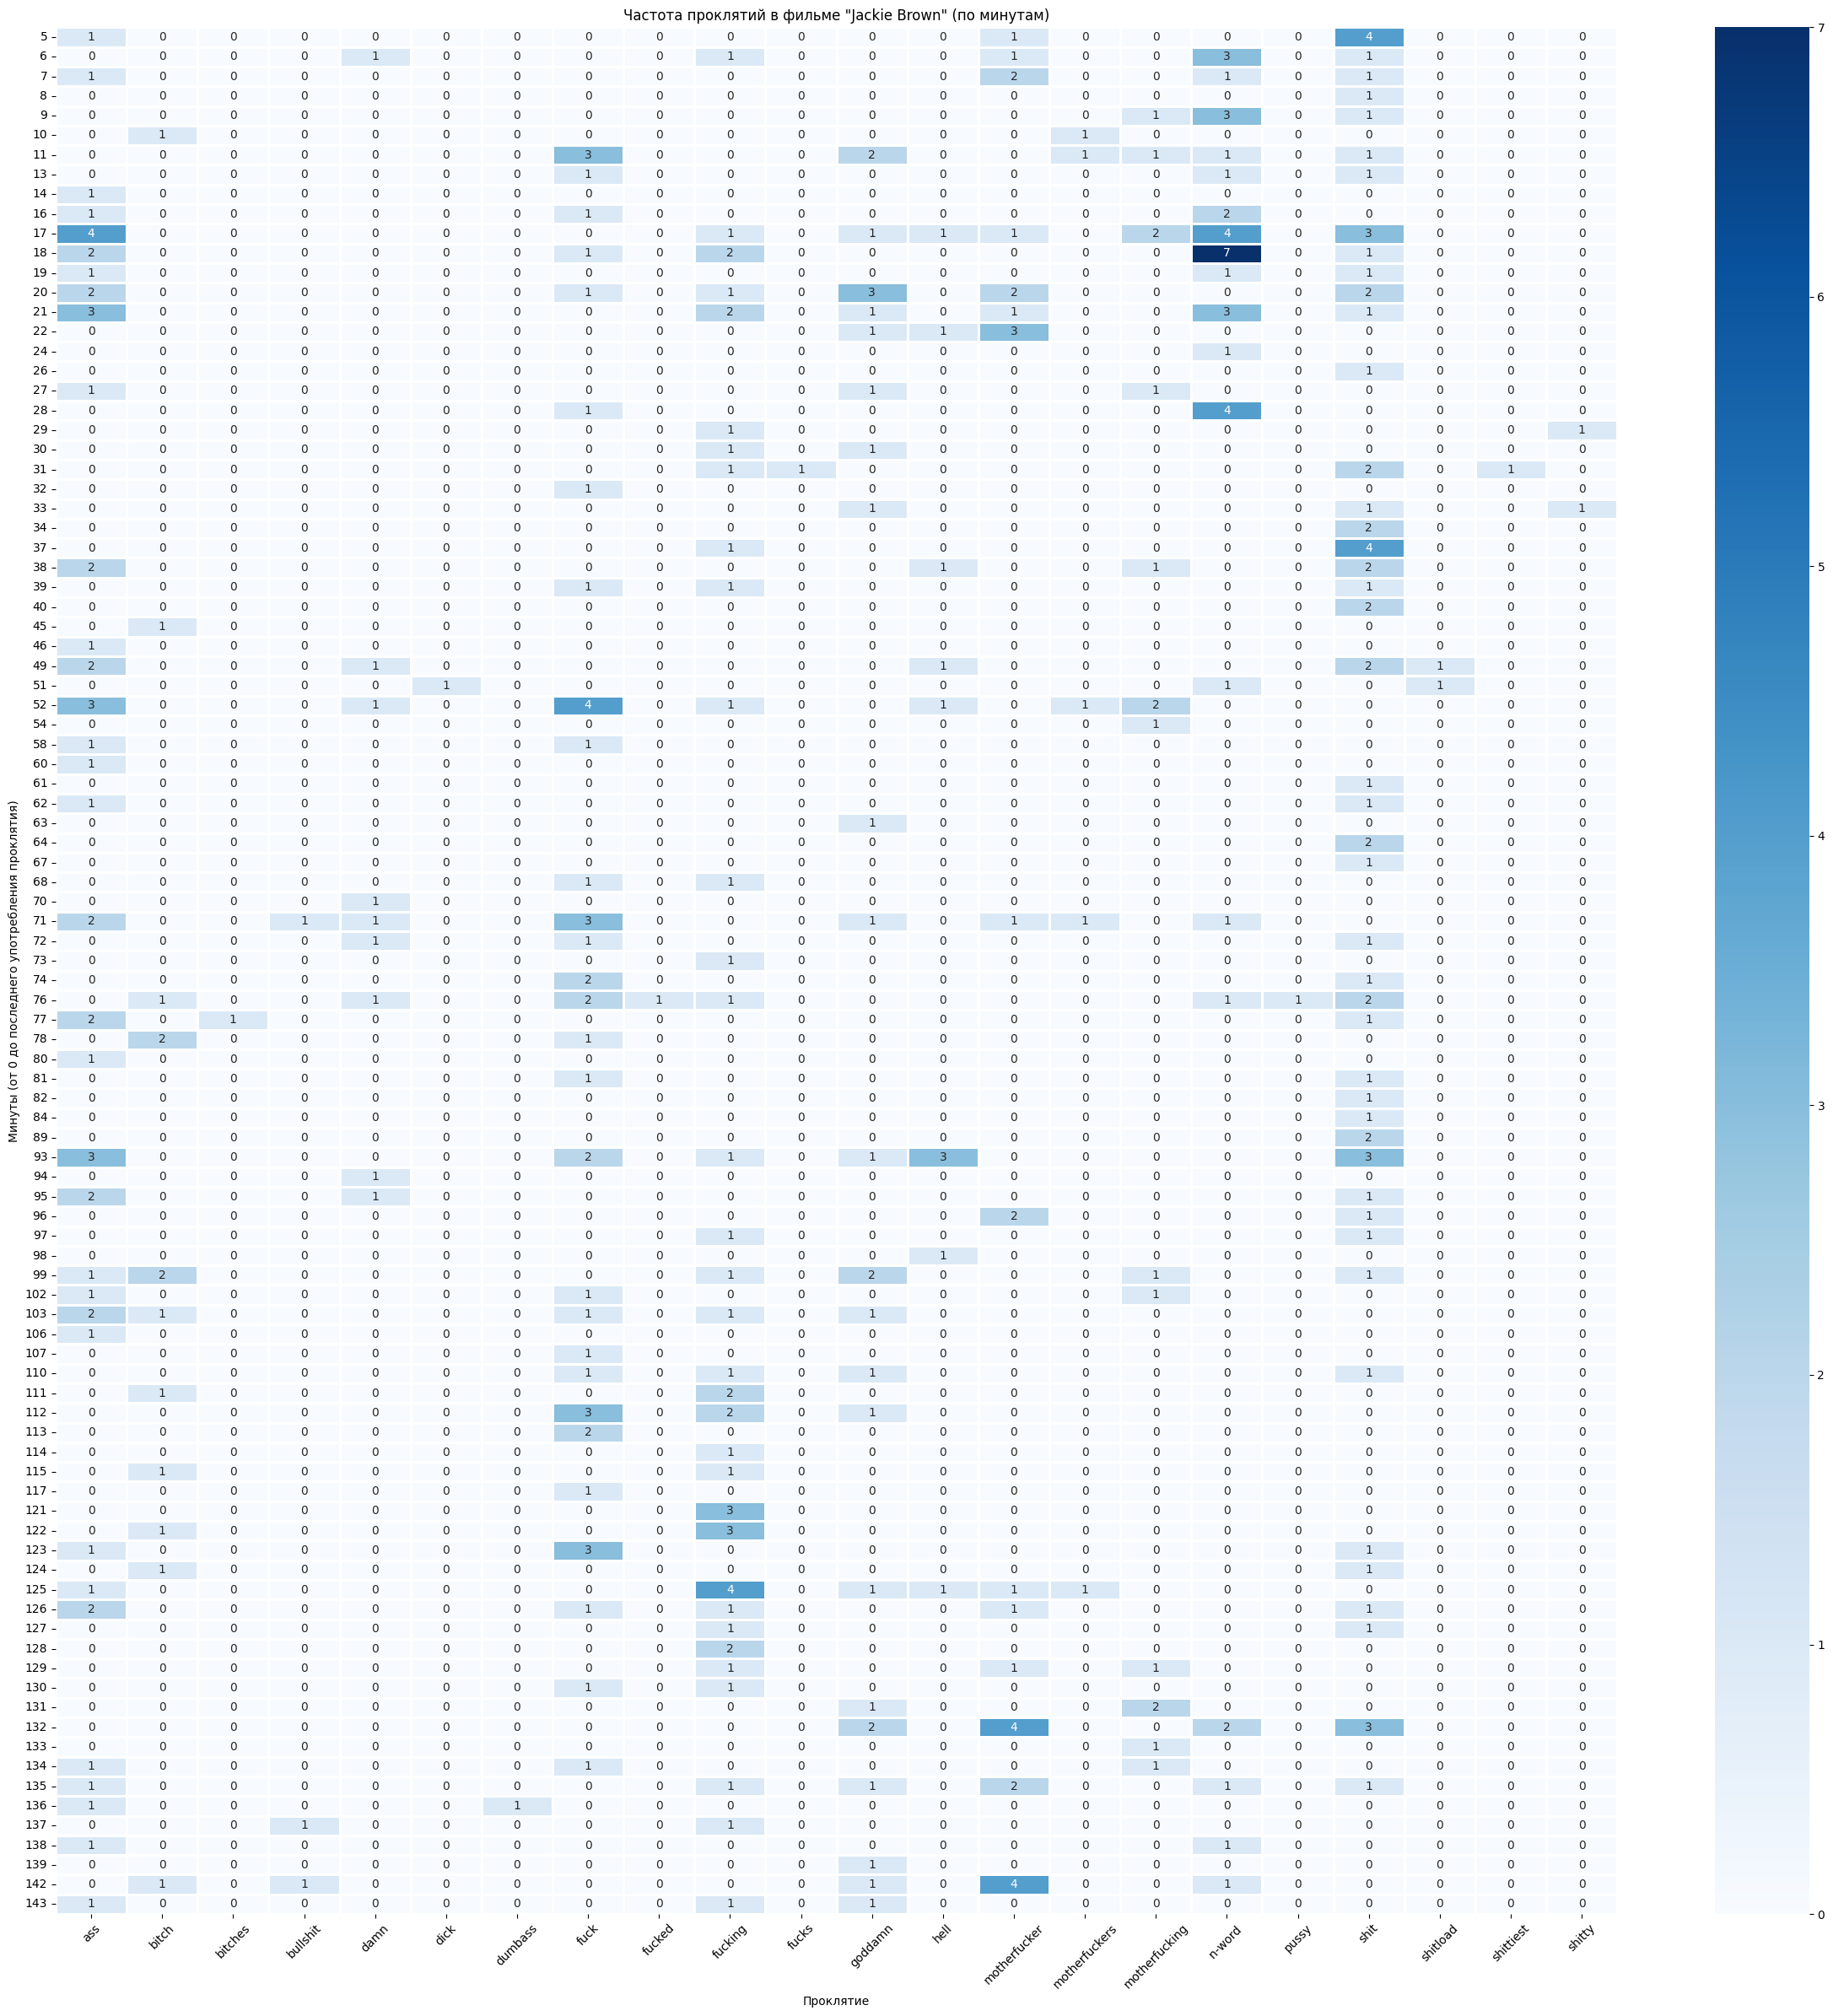

In [40]:
# Распределение проклятий по минутам для каждого фильма 
# (в каждой ячейке - количество употреблений слова за конкретную минуту (округление вверх))

movies = curses['movie'].unique()

# тепловая карта для каждого фильма
for movie in movies:
    # фильтрация данных по фильму
    movie_data = curses[curses['movie'] == movie]
    # округление времени употребления слова до большей минуты
    movie_data['minute'] = np.ceil(movie_data['minutes_in']).astype(int)
    
    # группировка по минутам и словам
    heatmap_data = movie_data.groupby(['minute', 'word']).size().unstack(fill_value=0)
    
    plt.figure(figsize=(24, 24))
    sns.heatmap(heatmap_data, cmap="Blues", annot=True, fmt="d", linewidths=1)
    plt.title(f'Частота проклятий в фильме "{movie}" (по минутам)')
    plt.xlabel('Проклятие')
    plt.ylabel('Минуты (от 0 до последнего употребления проклятия)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()